# Time Series Project - Zillow Data

## Introduction
For this project, you will be acting as a consultant for a fictional real-estate investment firm. The firm has asked you what seems like a simple question:

> what are the top 5 best zipcodes for us to invest in?

This may seem like a simple question at first glance, but there's more than a little ambiguity here that you'll have to think through in order to provide a solid recommendation. Should your recommendation be focused on profit margins only? What about risk? What sort of time horizon are you predicting against?  Your recommendation will need to detail your rationale and answer any sort of lingering questions like these in order to demonstrate how you define "best".

As mentioned previously, the data you'll be working with comes from the [Zillow Research Page](https://www.zillow.com/research/data/). However, there are many options on that page, and making sure you have exactly what you need can be a bit confusing. For simplicity's sake, we have already provided the dataset for you in this repo--you will find it in the file `zillow_data.csv`.

## The Deliverables
The goal of this project is to have you complete a very common real-world task in regard to Time-Series Modeling. However, real world problems often come with a significant degree of ambiguity, which requires you to use your knowledge of statistics and data science to think critically about and answer. While the main task in this project is Time-Series Modeling, that isn't the overall goal--it is important to understand that Time-Series Modeling is a tool in your toolbox, and the forecasts it provides you are what you'll use to answer important questions.

In short, to pass this project, demonstrating the quality and thoughtfulness of your overall recommendation is at least as important as successfully building a Time-Series model!

Online students should complete the following 4 deliverables for this project:

* A well-documented **_Jupyter Notebook_** containing any code you've written for this project (use the notebook in this repo, `mod_4_starter_notebook.ipynb`). This work will need to be pushed to your GitHub repository in order to submit your project.
* An organized **README.md** file in the GitHub repository that describes the contents of the repository. This file should be the source of information for navigating through the repository.
* A **_[Blog post](https://github.com/learn-co-curriculum/dsc-welcome-blogging)_**.
* An **_'Executive Summary' PowerPoint Presentation_** that explains your rationale and methodology for determining the best zipcodes for investment.


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [2]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
plt.style.use('ggplot')

In [3]:
#Load the zillow dataset from zillow_data.csv
zill = pd.read_csv("zillow_data.csv")

In [4]:
zill.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [5]:
zill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


#### Zip Code Selection.
This project is open ended in terms of selecting the "best" zip code to invest in. With almost 15,000 zip code available I chose to focus on Austin, TX. Austin is one of the fastest growing major cities in the US. Growing population is one factor in housing prices there are many others: for example builing regulations, space to expand, rental market, job growth, type of job market ... 

Travis County (which contains Austin) has 44 zip codes. Even 44 zip codes is time consuming to model, so I looked for another data source to help simplify the project.  Using census estimate data for 2017, I selected the 10 zip codes with the largest population in Travis County. I chose the largest populations to ensure that each zip code has a large real estate market, and is less likely to be skewed by a few outliers.

Austin census data source:  
https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_17_5YR_B01003&prodType=table


In [6]:
Travis = pd.read_csv("Travis_County_pop.csv")

In [7]:
Travis.head()

RegionName          City State   Metro CountyName  2017_po  2010_pop  \
0       78660  Pflugerville    TX  Austin     Travis    85450     68789   
1       78745        Austin    TX  Austin     Travis    62220     55614   
2       78753        Austin    TX  Austin     Travis    58693     49301   
3       78741        Austin    TX  Austin     Travis    52307     44935   
4       78748        Austin    TX  Austin     Travis    49142     40651   

   Growth  
0    0.24  
1    0.12  
2    0.19  
3    0.16  
4    0.21

In [8]:
len(Travis)

44

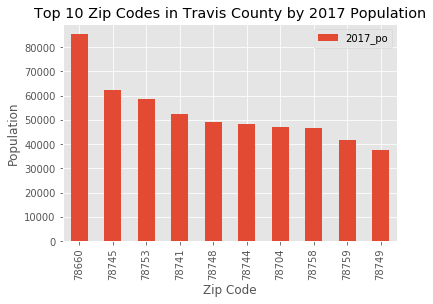

In [9]:
Travis_top = Travis.nlargest(10, '2017_po')
ax = Travis_top.plot.bar(x='RegionName', y='2017_po')
ax.set_xlabel('Zip Code')
ax.set_ylabel('Population')
ax.set_title('Top 10 Zip Codes in Travis County by 2017 Population')
plt.show()

In [10]:
Travis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 8 columns):
RegionName    44 non-null int64
City          44 non-null object
State         44 non-null object
Metro         44 non-null object
CountyName    44 non-null object
2017_po       44 non-null int64
2010_pop      44 non-null int64
Growth        44 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.8+ KB


Convert the top 10 zip codes into a list which will be applied as a filter to the Zillow dataframe

In [11]:
travis_10 = list(Travis.nlargest(10, '2017_po')['RegionName'])

In [12]:
travis_10

[78660, 78745, 78753, 78741, 78748, 78744, 78704, 78758, 78759, 78749]

In [13]:
austin = zill[zill['RegionName'].isin(travis_10)]

In [14]:
austin

RegionID  RegionName          City State   Metro CountyName  SizeRank  \
18       92593       78660  Pflugerville    TX  Austin     Travis        19   
66       92617       78704        Austin    TX  Austin     Travis        67   
98       92654       78745        Austin    TX  Austin     Travis        99   
422      92667       78758        Austin    TX  Austin     Travis       423   
432      92651       78741        Austin    TX  Austin     Travis       433   
502      92662       78753        Austin    TX  Austin     Travis       503   
507      92668       78759        Austin    TX  Austin     Travis       508   
594      92657       78748        Austin    TX  Austin     Travis       595   
1671     92653       78744        Austin    TX  Austin     Travis      1672   
1936     92658       78749        Austin    TX  Austin     Travis      1937   

       1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
18    138900.0  138600.0  138400.0  ...   235000   235900   236600   237400   
66    221300.0  221100.0  221000.0  ...   530100   532400   534200   536200   
98    135000.0  134200.0  133800.0  ...   286300   286900   287500   288700   
422   129000.0  128300.0  127500.0  ...   250000   248400   247500   247400   
432    93800.0   93600.0   93500.0  ...   228000   226700   227600   230200   
502   111300.0  110600.0  109900.0  ...   222600   223200   223600   223100   
507   266400.0  269000.0  272000.0  ...   429700   431100   433000   435800   
594   199500.0  198800.0  197900.0  ...   268400   268700   270100   272600   
1671   85400.0   85400.0   85300.0  ...   180300   182900   186000   188400   
1936  264000.0  266400.0  269300.0  ...   350900   350400   349400   348900   

      2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
18     238500   239400   240000   241000   242200   242800  
66     538200   539800   540200   542300   547100   550900  
98     289800   290500   291300   292600   294000   294700  
422    247900   250500   255100   260100   266000   270400  
432    234100   238300   241000   243600   247400   250400  
502    223100   225000   227100   228700   231500   233400  
507    439400   442400   443200   445000   449900   454100  
594    274900   276700   277800   279000   280800   282000  
1671   189700   190900   192100   193200   194500   195500  
1936   348700   348900   349700   352100   355500   357700  

[10 rows x 272 columns]

The resulting dataframe is now the top 10 Austin zip codes

In [15]:
# check for null values
austin.isna().sum().sum()

0

In [16]:
austin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 18 to 1936
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 21.3+ KB


# Step 2: Data Preprocessing and Reshaping

## Converting the data into time series format

In [17]:
def get_datetimes(austin):
    return pd.to_datetime(austin.columns.values[1:], format='%Y-%m')

In [18]:
austin

RegionID  RegionName          City State   Metro CountyName  SizeRank  \
18       92593       78660  Pflugerville    TX  Austin     Travis        19   
66       92617       78704        Austin    TX  Austin     Travis        67   
98       92654       78745        Austin    TX  Austin     Travis        99   
422      92667       78758        Austin    TX  Austin     Travis       423   
432      92651       78741        Austin    TX  Austin     Travis       433   
502      92662       78753        Austin    TX  Austin     Travis       503   
507      92668       78759        Austin    TX  Austin     Travis       508   
594      92657       78748        Austin    TX  Austin     Travis       595   
1671     92653       78744        Austin    TX  Austin     Travis      1672   
1936     92658       78749        Austin    TX  Austin     Travis      1937   

       1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  2017-10  \
18    138900.0  138600.0  138400.0  ...   235000   235900   236600   237400   
66    221300.0  221100.0  221000.0  ...   530100   532400   534200   536200   
98    135000.0  134200.0  133800.0  ...   286300   286900   287500   288700   
422   129000.0  128300.0  127500.0  ...   250000   248400   247500   247400   
432    93800.0   93600.0   93500.0  ...   228000   226700   227600   230200   
502   111300.0  110600.0  109900.0  ...   222600   223200   223600   223100   
507   266400.0  269000.0  272000.0  ...   429700   431100   433000   435800   
594   199500.0  198800.0  197900.0  ...   268400   268700   270100   272600   
1671   85400.0   85400.0   85300.0  ...   180300   182900   186000   188400   
1936  264000.0  266400.0  269300.0  ...   350900   350400   349400   348900   

      2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
18     238500   239400   240000   241000   242200   242800  
66     538200   539800   540200   542300   547100   550900  
98     289800   290500   291300   292600   294000   294700  
422    247900   250500   255100   260100   266000   270400  
432    234100   238300   241000   243600   247400   250400  
502    223100   225000   227100   228700   231500   233400  
507    439400   442400   443200   445000   449900   454100  
594    274900   276700   277800   279000   280800   282000  
1671   189700   190900   192100   193200   194500   195500  
1936   348700   348900   349700   352100   355500   357700  

[10 rows x 272 columns]

## Reshape from Wide to Long Format

In [19]:
def melt_data(austin):
    melted = pd.melt(austin, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [20]:
zip_dict = {}
for z in austin.RegionName.unique():
    temp_df = austin[austin.RegionName == z]
    zip_dict[z] = melt_data(temp_df)

In [21]:
zip_dict.keys()

dict_keys([78660, 78704, 78745, 78758, 78741, 78753, 78759, 78748, 78744, 78749])

In [22]:
# create dataframe for each zip code
df_78660 = (zip_dict[78660])
df_78704 = (zip_dict[78704])
df_78745 = (zip_dict[78745])
df_78758 = (zip_dict[78758])
df_78741 = (zip_dict[78741])
df_78753 = (zip_dict[78753])
df_78759 = (zip_dict[78759])
df_78748 = (zip_dict[78748])
df_78744 = (zip_dict[78744])
df_78749 = (zip_dict[78749])


In [23]:
df_78749.head()

value
time                
1996-04-01  264000.0
1996-05-01  266400.0
1996-06-01  269300.0
1996-07-01  272400.0
1996-08-01  275500.0

# Step 3: EDA and Visualization

## Visualization: Zip codes by house value

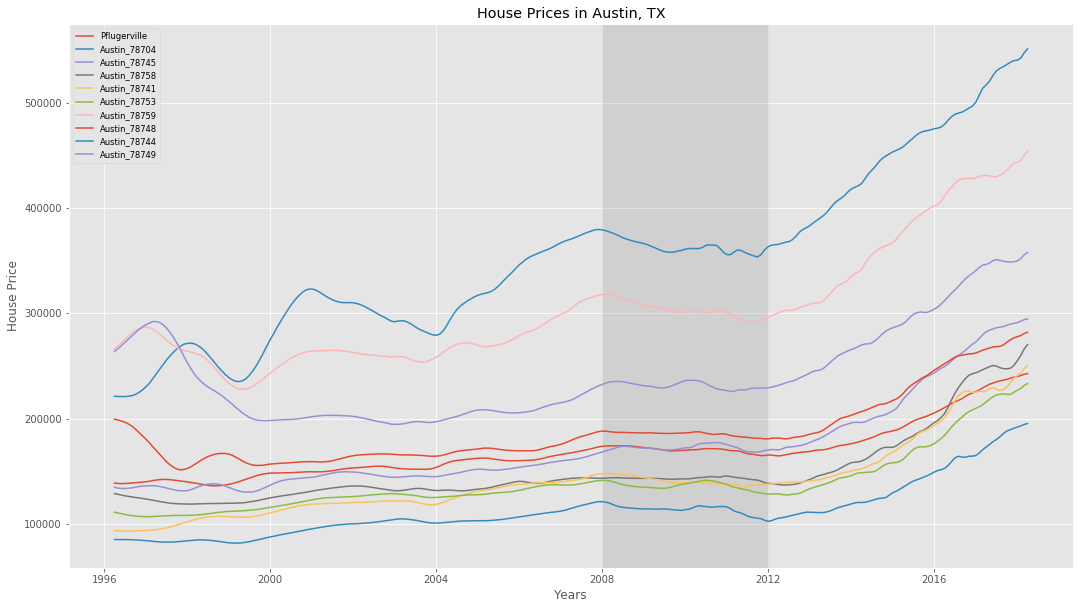

In [24]:
fig = plt.figure(figsize=(18,10))
plt.plot(df_78660, label='Pflugerville')
plt.plot(df_78704, label='Austin_78704')
plt.plot(df_78745, label='Austin_78745')
plt.plot(df_78758, label='Austin_78758')
plt.plot(df_78741, label='Austin_78741')
plt.plot(df_78753, label='Austin_78753')
plt.plot(df_78759, label='Austin_78759')
plt.plot(df_78748, label='Austin_78748')
plt.plot(df_78744, label='Austin_78744')
plt.plot(df_78749, label='Austin_78749')
plt.legend(loc='best', fontsize='small')

plt.ylabel('House Price')
plt.xlabel('Years')
plt.title('House Prices in Austin, TX')
plt.axvspan('2008', '2012', color='grey', alpha=0.2)
plt.show();


This chart shows the change in housing prices across all 10 zip codes, from 1996 to 2018. 
Note the effect of the financial crisis - house prices decline in 2008 and mainly continue to decline until 2012. After 2012 there is a steady increase in prices.

## Visualization: Zip codes by percentage change

Next we will compare all house prices by percentage change. I will start by looking at the zip code in monthly increments. If that has too much fluctuation I will convert the zip codes to an annualized mean for the visualization.

In [25]:
# visualize percentage change
pct_chg_78660 = df_78660['value'].pct_change()

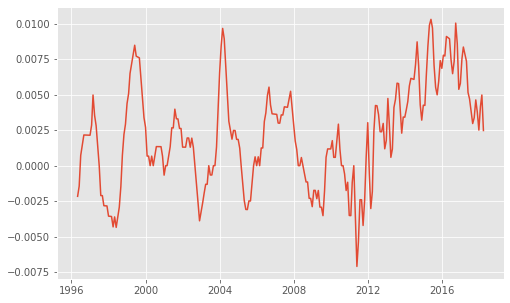

In [26]:
# test - percentage change at monthly increments ... looks too detailed
fig = plt.figure(figsize=(8,5))
plt.plot(pct_chg_78660, label='Pflugerville');

This does look like too much detail. Next step is to convert to annualized percentage change

In [27]:
# create new dataframes for each zip code with percentage change from year to year

pct_78660=df_78660['value'].resample('A').mean().pct_change()
pct_78704=df_78704['value'].resample('A').mean().pct_change()
pct_78745=df_78745['value'].resample('A').mean().pct_change()
pct_78758=df_78758['value'].resample('A').mean().pct_change()
pct_78741=df_78741['value'].resample('A').mean().pct_change()
pct_78753=df_78753['value'].resample('A').mean().pct_change()
pct_78759=df_78759['value'].resample('A').mean().pct_change()
pct_78748=df_78748['value'].resample('A').mean().pct_change()
pct_78744=df_78744['value'].resample('A').mean().pct_change()
pct_78749=df_78749['value'].resample('A').mean().pct_change()

### Percentage Change Visualization

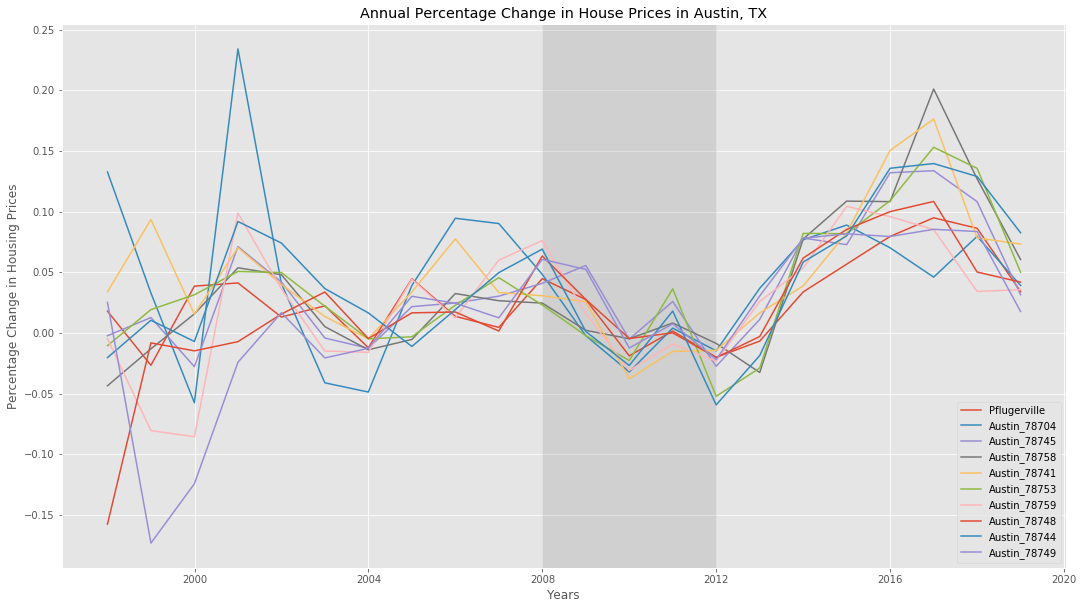

In [28]:
fig = plt.figure(figsize=(18,10))
for df in [pct_78660, pct_78704, pct_78745, pct_78758, pct_78741, pct_78753, pct_78759, pct_78748, pct_78744, pct_78749]:
    plt.plot(df)
    plt.legend(['Pflugerville', 'Austin_78704', 'Austin_78745', 'Austin_78758', 'Austin_78741', 
                'Austin_78753', 'Austin_78759', 'Austin_78748', 'Austin_78744', 'Austin_78749'])
plt.ylabel('Percentage Change in Housing Prices')
plt.xlabel('Years')
plt.title('Annual Percentage Change in House Prices in Austin, TX')
plt.axvspan('2008', '2012', color='grey', alpha=0.2)
plt.show();

There is some divergence in the early years, but from about 2004 onwards the annual percentage change looks similar across all zip codes. The decline from 2008 to 2012 is more dramatic on this chart.

## Visualization: High priced and low priced house comparison

The next visualization inspects the similarity and the spread between a high priced zip code (78704) and a low priced zip code (78744).

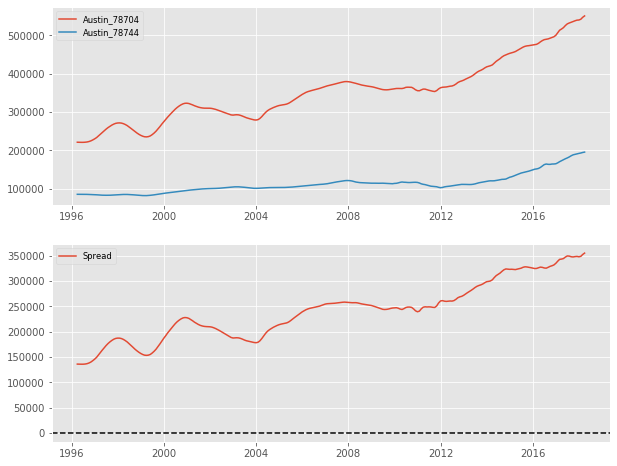

In [29]:
# Plot the prices separately
fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(df_78704, label='Austin_78704')
plt.plot(df_78744, label='Austin_78744')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(df_78704 - df_78744, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

The patterns between the 2 zip codes look similar, but the spread is overwhelmed by the size of the larger zip code. 
Next visualization looks at the same zip code by percentage change.

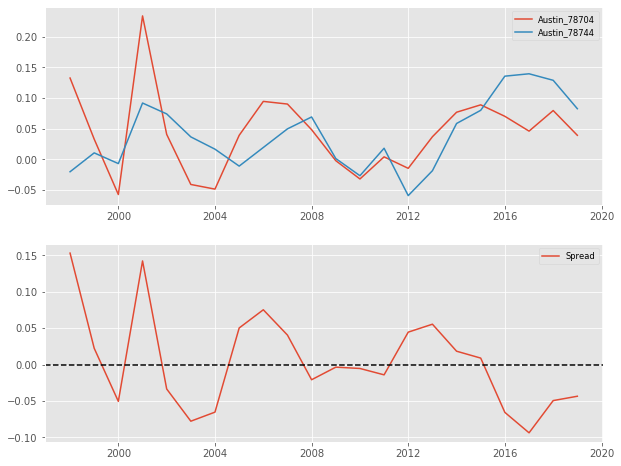

In [30]:
# Plot the prices separately
fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(pct_78704, label='Austin_78704')
plt.plot(pct_78744, label='Austin_78744')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(pct_78704 - pct_78744, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

Now we can see more clearly that the trends are similar. After 2003 every year is within +/- 8% (with the exception of 2017)

In [31]:
# Correlation of price changes
correlation = df_78704['value'].corr(df_78744['value'])
print("Correlation of price: ", correlation)

# Correlation of percent changes
correlation_chg = pct_78704.corr(pct_78744)
print("Correlation of changes: ", correlation_chg)

Correlation of price:  0.9450508091570009
Correlation of changes:  0.43264007792018316


Comparing the correlations - the price between these 2 zip codes is almost perfectly correlated. However, this can be misleading. Looking at the correlation of percentage change we see a medium correlation.

### The next few visuals will be performed using zip code 78660 only.
We will include all zip codes in the modelling stage

## Visualization ACF  and PACF

One of the main ways to choose the right model is by using the ACF (AutoCorrelation feature) and PACF (Partial Auto Correlation Feature)

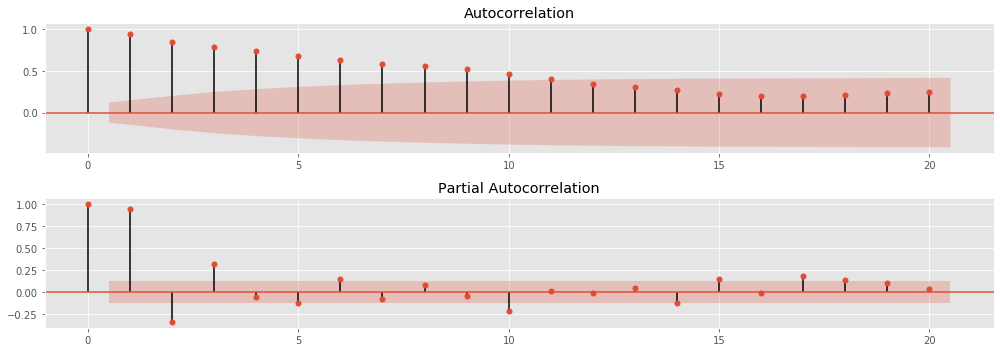

In [32]:
# Import the modules for plotting the sample ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

# Take first difference of the price
chg_price = df_78660.diff(periods=1)
chg_price = chg_price.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_price, lags=20, ax=axes[0] )

# Plot the PACF
plot_pacf(chg_price, lags=20, ax=axes[1])
fig.tight_layout()
plt.show();


Both the ACF and PACF trail off, rather than have a hard cut at a certain lag. This would indicate an ARMA model

## Stationarity Test

The Augmented Dickey Fuller test checks for stationarity. Stationarity means that distribution of the data does not change with time. If the data are stationary statistical properties such as mean and variance remain constant over time. Stationarity is a necessary condition for using an ARMA model

In [33]:
from statsmodels.tsa.stattools import adfuller

In [34]:
adfuller(df_78660['value'])

(1.6135418792199836,
 0.9978976393546417,
 10,
 254,
 {'1%': -3.456360306409983,
  '5%': -2.8729872043802356,
  '10%': -2.572870232500465},
 3312.4763069278183)

With a p-value of almost 1, we fail to reject the null hypothesis that the time series for zip code 78660 is not stationary.

In [35]:
# Try again with differencing

diff_78660 = df_78660.diff().dropna()

In [36]:
adfuller(diff_78660['value'])

(-2.140526454010565,
 0.22853390408272523,
 16,
 247,
 {'1%': -3.457105309726321,
  '5%': -2.873313676101283,
  '10%': -2.5730443824681606},
 3299.66593522679)

A first order difference is close to stationary, but not quite. The differenced time series fits the 10% test statistic threshold, but not the 5%. Our p-value is still too large to reject the null hypothesis

Next we'll perform some additional standardization techniques

#### Subtracting the Rolling Mean

In [37]:
#Determine rolling statistics
rolmean = df_78660.rolling(window = 12, center = False).mean()
rolstd = df_78660.rolling(window = 12, center = False).std()

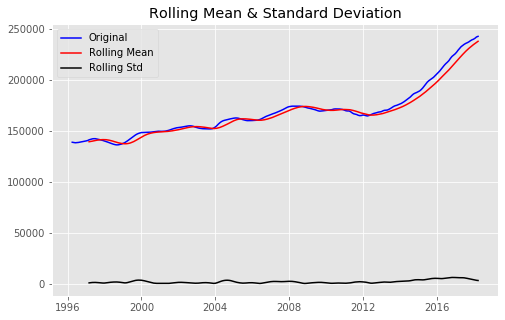

In [38]:
#Plot rolling statistics
fig = plt.figure(figsize=(8,5))
orig = plt.plot(df_78660, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [39]:
roll_78660 = (df_78660 - rolmean).dropna()

In [40]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(roll_78660['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -0.952835
p-value                          0.770076
#Lags Used                      16.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


The time series is still not stationary. In fact differencing was more sucessful than subtracting the rolling mean. Sometimes the simple model is the best! 

#### Weighted Moving Average of Log of the Time Series 

In [41]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = 12, center = False).mean()
    rolstd = TS.rolling(window = 12, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS['value']) 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Log of 78660 - Exp Rolling Mean')
    mean = plt.plot(rolmean, color='red', label='Exp Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Exp Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None


In [42]:
# plt.plot(np.log(df_78660))
# plt.plot(exp_rolmean)

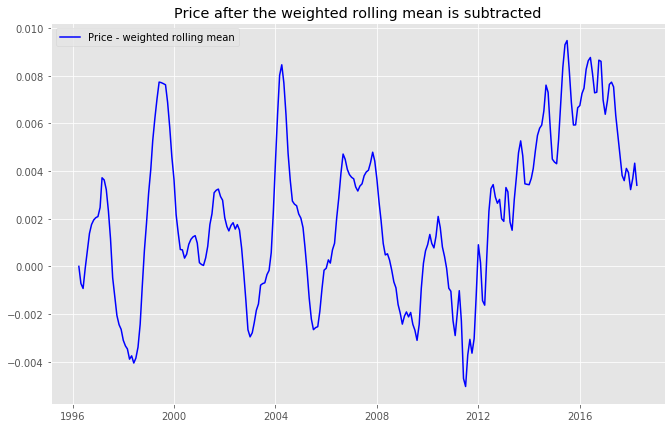

In [43]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
exp_rolmean = np.log(df_78660).ewm(halflife =1).mean()

# Subtract the moving average from the original data and plot
data_minus_exp_rolmean = np.log(df_78660) - exp_rolmean
#data_minus_exp_rolmean.head(15)

fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_rolmean, color='blue',label='Price - weighted rolling mean')
plt.legend(loc='best')
plt.title('Price after the weighted rolling mean is subtracted')
plt.show(block=False)

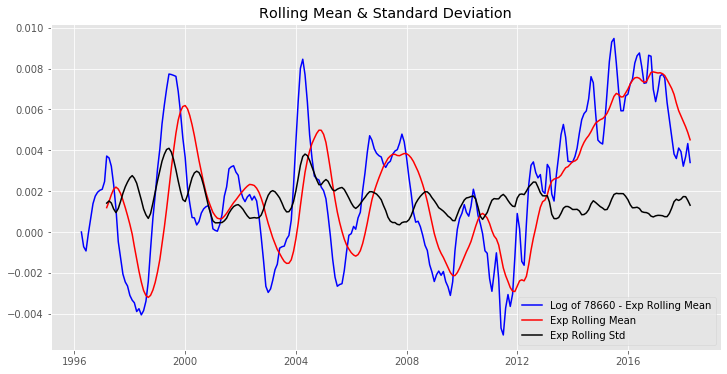

Results of Dickey-Fuller Test:
Test Statistic                  -1.836018
p-value                          0.362732
#Lags Used                      16.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [44]:
# do a stationarity check
stationarity_check(data_minus_exp_rolmean)

Even after subtracting the log of the weighted rolling mean, the time series for zip code 78660 is not stationary. Our first order difference is still the best model. This is understandable as the time series is additive vs multiplicative, and there are features in the data that may be hard to model - in particular the financial crisis and subsequent gain in value.

## Seasonal Decomposition

Decomposition helps us visualize a time series as a combination of trend, seasonality, and noise components. I will run this twice - on the first order difference, and on the log of the time series

In [45]:
#### Decomposition of Differenced Time Series

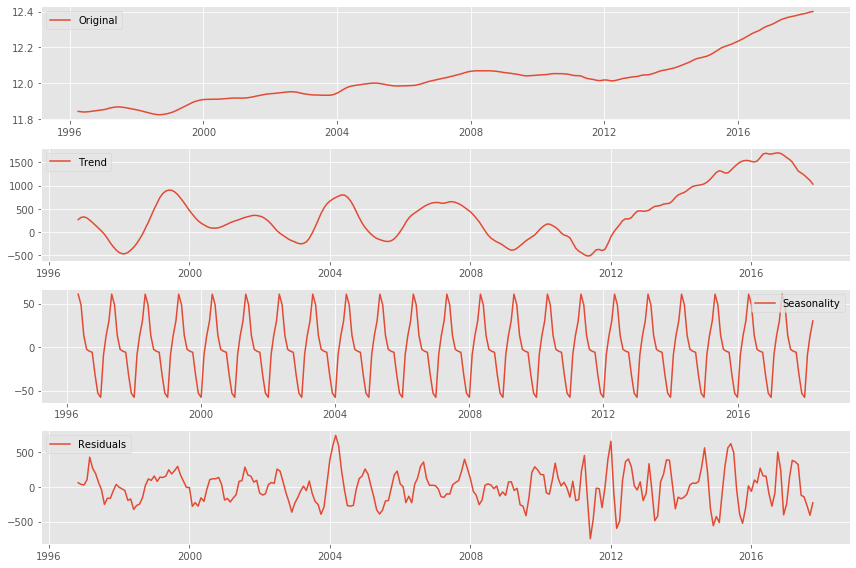

In [46]:
# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(diff_78660)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(df_78660), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [47]:
#### Decompostion of Log of Time Series

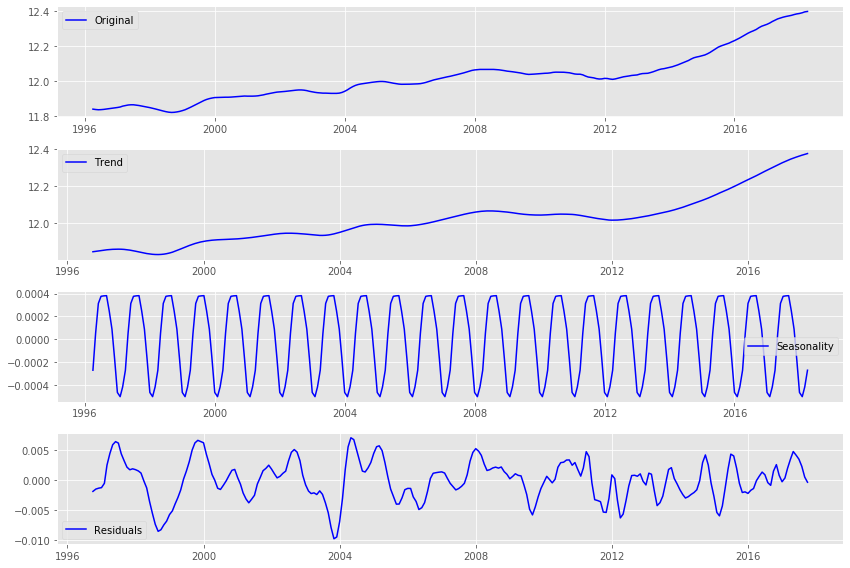

In [48]:
# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(np.log(df_78660))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(df_78660), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

Both visuals identify trend, seasonality and residuals. The trend is more stable on the log of the time series; it looks somewhat erratic on the differenced time series. Although seasonality is identified, the scale is tiny in comparision to the residuals.

# Step 4: ARIMA Modeling

In [49]:
# initialize zip code dataframe.
zipdf1 = pd.DataFrame()

## Zip Code 78660

In [50]:
zip = 78660
df_model = df_78660

### ARIMA model

First test a simple ARIMA model, with no seasonality

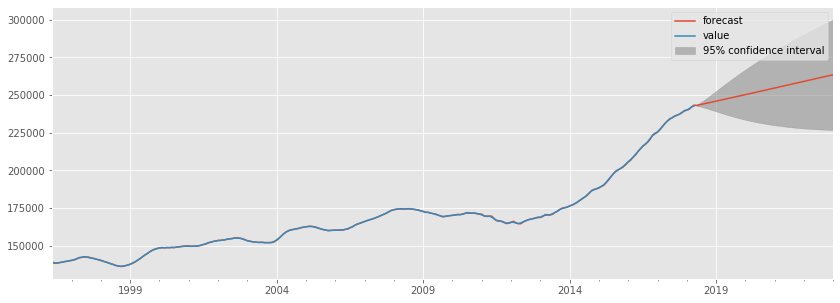

In [51]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast prices using an ARIMA(1,1,1) model
mod = ARIMA(df_model, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(end='2023-01-01')
plt.show()

In [52]:
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1770.241
Method:                       css-mle   S.D. of innovations            196.700
Date:                Mon, 28 Oct 2019   AIC                           3548.482
Time:                        01:21:32   BIC                           3562.786
Sample:                    05-01-1996   HQIC                          3554.230
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           368.7661    170.594      2.162      0.032      34.408     703.124
ar.L1.D.value     0.9012      0.027     33.530      0.000       0.849       0.954
ma.L1.D.value     0.4394      0.050     

In [53]:
print("The ARIMA model has an AIC of {}".format(round(res.aic,0)))

The ARIMA model has an AIC of 3548.0


Load the ARIMA model into SARIMAX, in order to access plot diagnosis

In [54]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_a = ARIMA_MODEL.fit()

print(output_a.summary())

                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1757.221
Date:                Mon, 28 Oct 2019   AIC                           3520.441
Time:                        01:21:33   BIC                           3531.146
Sample:                    04-01-1996   HQIC                          3524.744
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9301      0.019     48.582      0.000       0.893       0.968
ma.L1          0.4308      0.053      8.183      0.000       0.328       0.534
sigma2      3.911e+04   2932.469     13.338      0.0

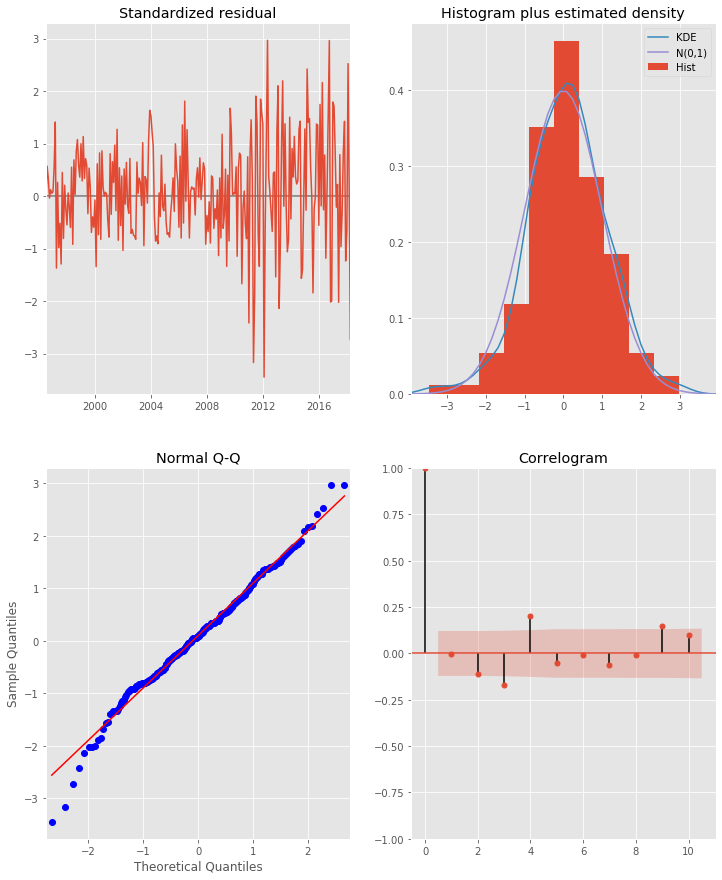

In [55]:
# Use plot_diagnostics with results calculated above.
output_a.plot_diagnostics(figsize=(12, 15))
plt.show()

These 4 plots give us a measure of how good the model is, by focussing on the residuals - the difference between the predictions and the true values.
    * Standardize Residual - residuals should have no obivious pattern
    * Histogram - the distribution of the residuals line should be almost the same as the normal distribution line
    * Q-Q - the residuals should lie on the line, apart from the very end of the distribution
    * Correlogram - a ACF of the residuals, almost of the lags greater than zero should not be significant.
    
In this case the first 3 plots look good, but in the 4th there are 2 or 3 lag values that appear to be significant.

Other important statistics can be found in the summary table.
    * Prob(Q): tests whether the residuals have no correlation structure
    * Prob(JB): tests whether the rsiduals are normally distributed
    
In both of these cases

### SARIMAX model

The code below tests different combinations of the model and returns an AIC value for each. From this we can select the best model

In [56]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [57]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_model,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7110.587697618226
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6623.899955725128
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5264.848176895204
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5025.453650824729
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5165.372016970405
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5148.7590515486045
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4895.107418271078
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =4865.187438085901
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6893.750992951365
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6865.46053338591
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5242.670395391708
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =6730.540914301953
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6983.105745343778
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6516.6098976930425
ARIMA (0, 0, 1) x (

In [58]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]



pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic            3265.4
Name: 59, dtype: object

In [59]:
print("The best model is ARIMA {}".format(ans_df.loc[ans_df['aic'].idxmin()].values))

The best model is ARIMA [(1, 1, 1) (0, 1, 1, 12) 3265.40255795385]


### Model Output and Plot Diagnostics

### Best fit using loop

Now run the model using the parameters above

In [60]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1628.701
Date:                            Mon, 28 Oct 2019   AIC                           3265.403
Time:                                    01:22:17   BIC                           3279.292
Sample:                                04-01-1996   HQIC                          3271.000
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8882      0.023     37.977      0.000       0.842       0.934
ma.L1          0.4649      0.041   

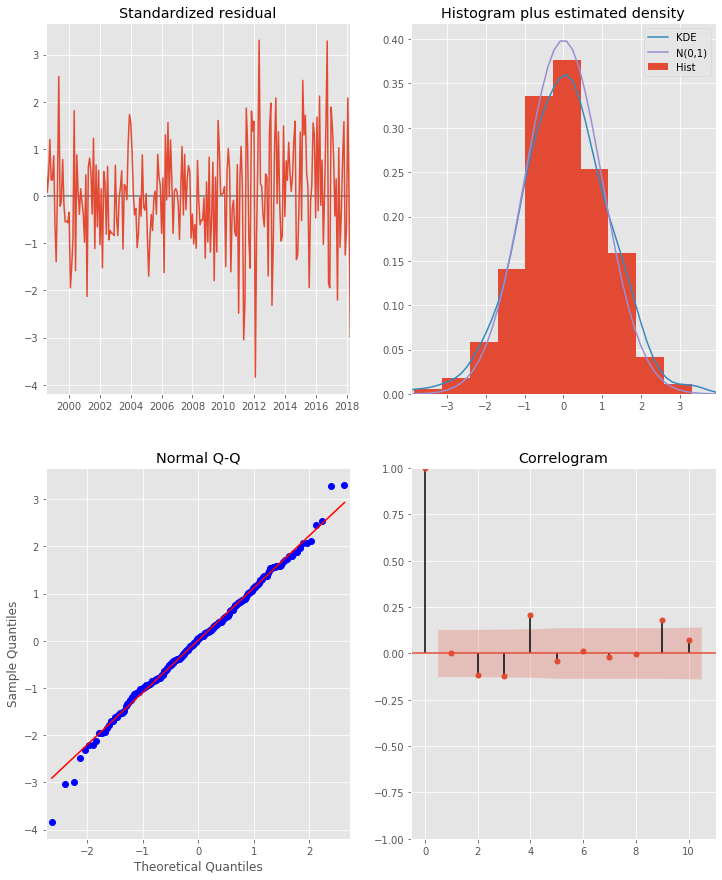

In [61]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

My concern with this model is the correlogram. There are several values that are significant or close to significant. This is also revealed in the Prob(Q) value of 0, which would have us reject the null hypothesis that the residuals have no correlation structure

### Best fit with higher order model

I also ran a higher order loop earlier, which returned the following parameters. I have not included the calculation in this notebook, because it took a long time to run and returned over 700 lines. I will run this model and compare the parameters.

In [62]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 2, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1484.789
Date:                            Mon, 28 Oct 2019   AIC                           2983.579
Time:                                    01:22:38   BIC                           3007.075
Sample:                                04-01-1996   HQIC                          2993.075
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4654      0.107      4.334      0.000       0.255       0.676
ma.L1         -1.1405      0.224   

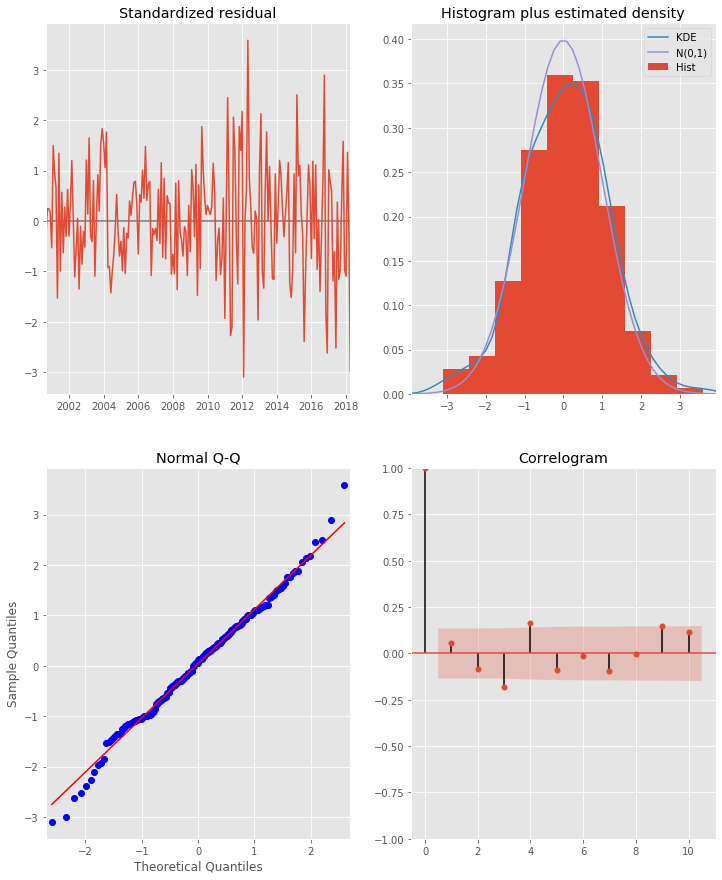

In [63]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

This model has a slightly supperior AIC. However it is more complicated and has a higher order of differencing, so it is debatable whether it is a better more. 

This model also did not solve the problem with the correlogram. Once again there are several values that are significant or close to significant, and the Prob(Q) value is also 0.


### Auto Arima

The pmdarima package has an auto_arima function that allows us to set a range of parameters and then fit models for all the possible combinations. The model will keep the combination with the best AIC value.

However in my testing the SARIMAX outperformed this package.

In [64]:
import pmdarima as pm

In [65]:
stepwise_model = pm.auto_arima(df_78660, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           information_criterion='aic',
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4052.196, BIC=4069.843, Fit time=3.110 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4046.549, BIC=4053.608, Fit time=0.046 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4038.610, BIC=4052.728, Fit time=1.572 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4039.577, BIC=4053.695, Fit time=2.028 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4037.200, BIC=4047.788, Fit time=0.537 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=4038.809, BIC=4052.927, Fit time=1.752 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 1, 12); AIC=4041.582, BIC=4059.229, Fit time=3.624 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4030.111, BIC=4044.229, Fit time=0.676 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4028.212, BIC=4045.859, Fit time=1.199 seconds
Fit ARIMA: order=(3, 1, 2) s

In [66]:
print(stepwise_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 12)   Log Likelihood               -1999.537
Date:                            Mon, 28 Oct 2019   AIC                           4007.073
Time:                                    01:23:23   BIC                           4021.191
Sample:                                         0   HQIC                          4012.754
                                            - 265                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.7948     10.400      1.615      0.106      -3.588      37.178
ar.L1          0.8141      0.046   

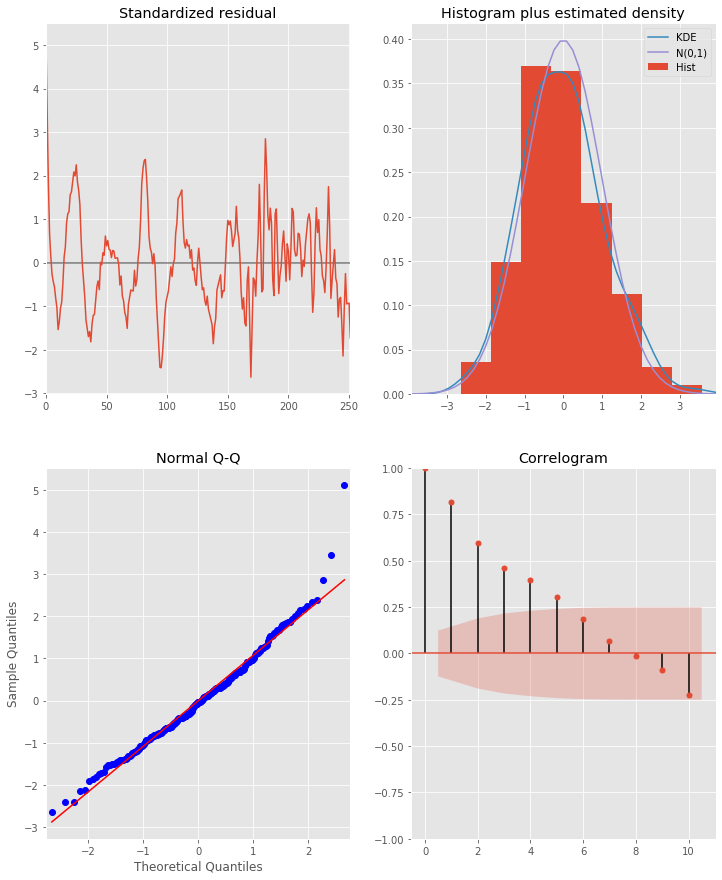

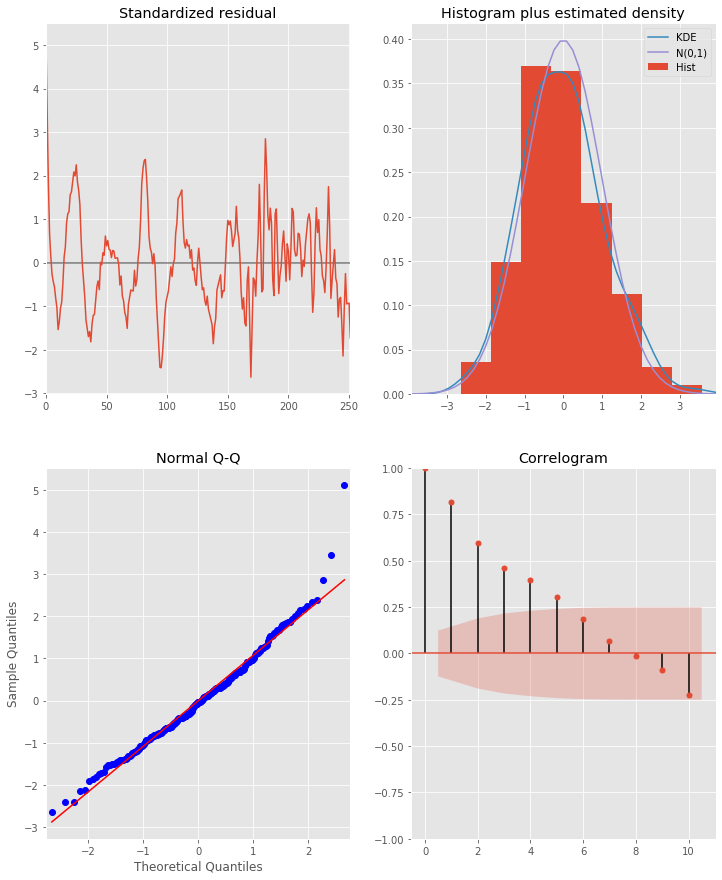

In [67]:
stepwise_model.plot_diagnostics(figsize=(12,15))

### Test Train Split

This point would be where we fit the model to a training data set, and then use the remaining portion of the data as a test. Once we are satisfied with the result we would refit the model to the entire database and forecast the future!

In the interests of time and space I have not done this in this project. The code would look something like:

In [68]:
# train = data.loc['1996-04':'2015-12']
# test = data.loc['2016-01':]

# output.fit(train)

### Get Predictions

In [69]:
df_zip = df_model['value'].resample('MS').mean()

#### One Step Ahead

First building a "one step ahead model" where each predicted value is based on the actual value immediately before it

In [70]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

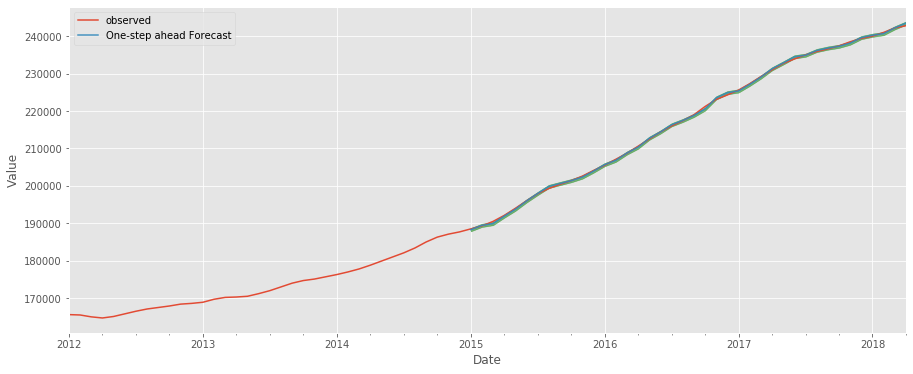

In [71]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = df_zip['2012':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

plt.show()

As expected, the "one step ahead" forecast is very close the actual value. We are only forecasting a month ahead each time, so this is not a realistic model

In [72]:
# Get the Real and predicted values
forecasted = pred.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 93651.21


#### Dynamic Prediction

Now our forecast uses the previous predicted value to make its next prediction. In this case the forecast begins in 2015 

In [73]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

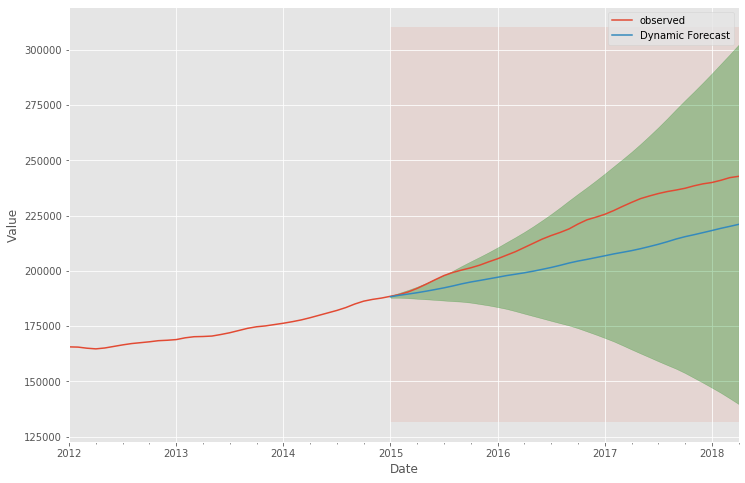

In [74]:
# Plot the dynamic forecast with confidence intervals as above
ax = df_zip['2012':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.legend()
plt.show()


This forecast diverges from the actual a lot more than the one step ahead model

In [75]:
# Extract the predicted and true values of our time series
forecasted = pred_dynamic.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 255369539.45


The Mean Squared Error looks massive, because it is based on house values in hundreds of thousands of dollars, which are then squared. To see how it relates to housing prices we need to take the square root of it.

In [76]:
mse_sqrt = np.sqrt(mse)
print("The Square Root of the MSE at {} doesn't look as bad".format(round(mse_sqrt,0)))

The Square Root of the MSE at 15980.0 doesn't look as bad


### Forecasting the future

In [77]:
# Get the forecast 60 months ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

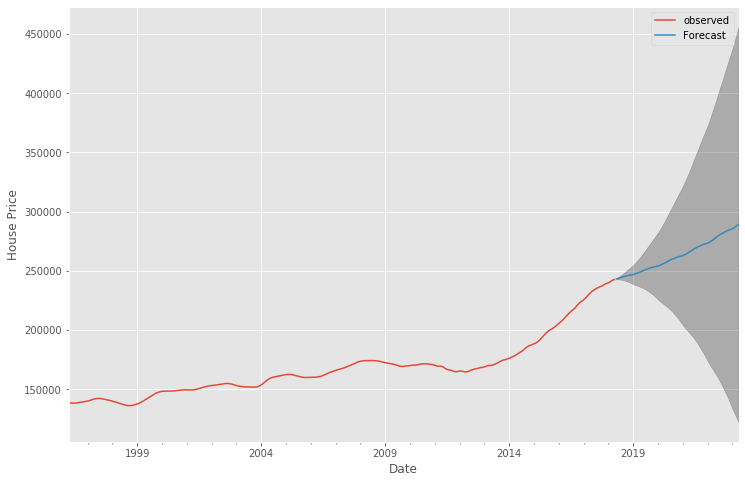

In [78]:
# Plot future predictions with confidence intervals

ax = df_zip.plot(label='observed', figsize=(12,8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Price')

plt.legend()
plt.show()

This forecast builds into the future. It shows the next 60 steps, or 5 years, or until 04-2023. There is a very large area under the confidence intervals - uncertainty increases dramatically after the first year or two.

#### Building a table of zip code forecasts

In [79]:
fcst = (output.forecast(steps=60).tail(1).sum())
actual = df_model.iloc[-1].value

In [80]:
fcst

289337.6308951326

In [81]:
actual

242800.0

In [82]:
zipdf2 = pd.DataFrame({"zip":[zip], 
                    "last_actual":[actual],
                    "last_fcst":fcst}) 

In [83]:
zipdf1 = zipdf1.append(zipdf2)

## Zip Code 78704

In [84]:
zip = 78704
df_model = df_78704

### ARIMA model

First test a simple ARIMA model, with no seasonality

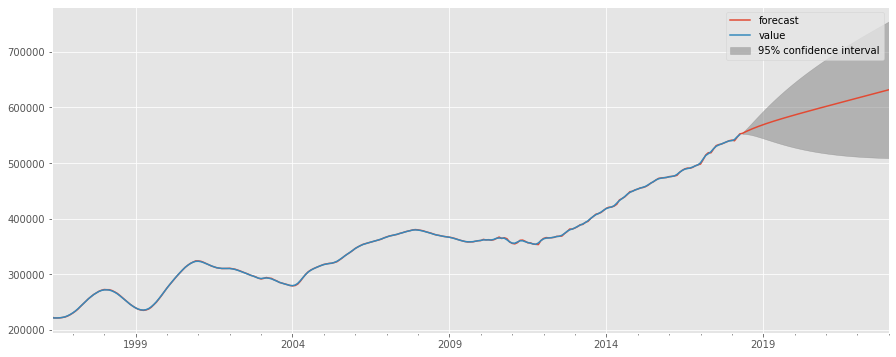

In [85]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast prices using an ARIMA(1,1,1) model
mod = ARIMA(df_model, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(end='2023-01-01')
plt.show()

In [86]:
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2081.656
Method:                       css-mle   S.D. of innovations            638.973
Date:                Mon, 28 Oct 2019   AIC                           4171.312
Time:                        01:23:29   BIC                           4185.616
Sample:                    05-01-1996   HQIC                          4177.059
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1240.1315    557.614      2.224      0.027     147.229    2333.034
ar.L1.D.value     0.8805      0.029     30.458      0.000       0.824       0.937
ma.L1.D.value     0.7434      0.036     

In [87]:
print("The ARIMA model has an AIC of {}".format(round(res.aic,0)))

The ARIMA model has an AIC of 4171.0


Load the ARIMA model into SARIMAX, in order to access plot diagnosis

In [88]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_a = ARIMA_MODEL.fit()

print(output_a.summary())

                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2105.068
Date:                Mon, 28 Oct 2019   AIC                           4216.137
Time:                        01:23:29   BIC                           4226.842
Sample:                    04-01-1996   HQIC                          4220.439
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9297      0.020     45.724      0.000       0.890       0.970
ma.L1          0.3391      0.012     27.348      0.000       0.315       0.363
sigma2      5.022e+05   2.92e+04     17.220      0.0

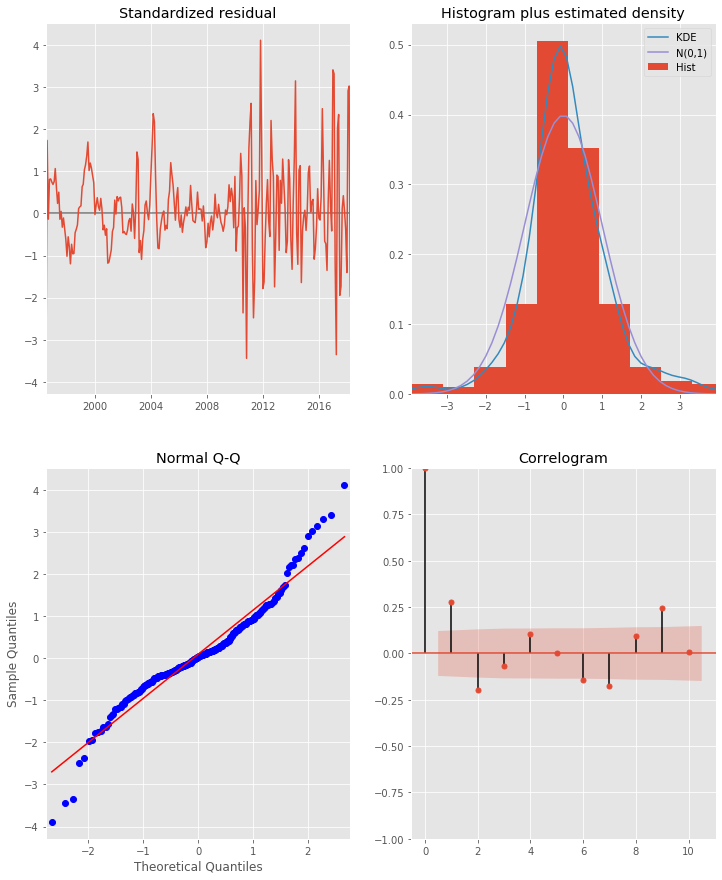

In [89]:
# Use plot_diagnostics with results calculated above.
output_a.plot_diagnostics(figsize=(12, 15))
plt.show()

These 4 plots give us a measure of how good the model is, by focussing on the residuals - the difference between the predictions and the true values.
    * Standardize Residual - residuals should have no obivious pattern
    * Histogram - the distribution of the residuals line should be almost the same as the normal distribution line
    * Q-Q - the residuals should lie on the line, apart from the very end of the distribution
    * Correlogram - a ACF of the residuals, almost of the lags greater than zero should not be significant.
    
None of these plots look good, the patterns of the residuals changes, the KDE line is different from the N(0,1) line, the Q-Q residuals don't lie on the red line and there are many lag values that appear to be significant.

Other important statistics can be found in the summary table.
    * Prob(Q): tests whether the residuals have no correlation structure
    * Prob(JB): tests whether the residuals are normally distributed
    
In both of these cases we reject the null hypothesis - there is correlation and the residuals are not normally distributed

### SARIMAX model

The code below tests different combinations of the model and returns an AIC value for each. From this we can select the best model

In [90]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [91]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_model,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7510.129730438364
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =7010.7774750423905
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5854.836682600474
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5566.15687466436
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5783.906732035761
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5740.444591578259
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5558.174759182313
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5523.470152931737
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7291.539921705708
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6916.1641966015695
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5873.465589461847
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =8030.455697030164
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6950.527874281749
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6897.5044266173545
ARIMA (0, 0, 1) x 

In [92]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]



pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           3901.41
Name: 63, dtype: object

In [93]:
print("The best model is ARIMA {}".format(ans_df.loc[ans_df['aic'].idxmin()].values))

The best model is ARIMA [(1, 1, 1) (1, 1, 1, 12) 3901.4080466762025]


### Model Output and Plot Diagnostics

### Best fit using loop

Now run the model using the parameters above

In [376]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1882.164
Date:                            Mon, 28 Oct 2019   AIC                           3774.328
Time:                                    02:04:33   BIC                           3791.690
Sample:                                04-01-1996   HQIC                          3781.325
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8273      0.036     23.049      0.000       0.757       0.898
ma.L1          0.7118      0.035   

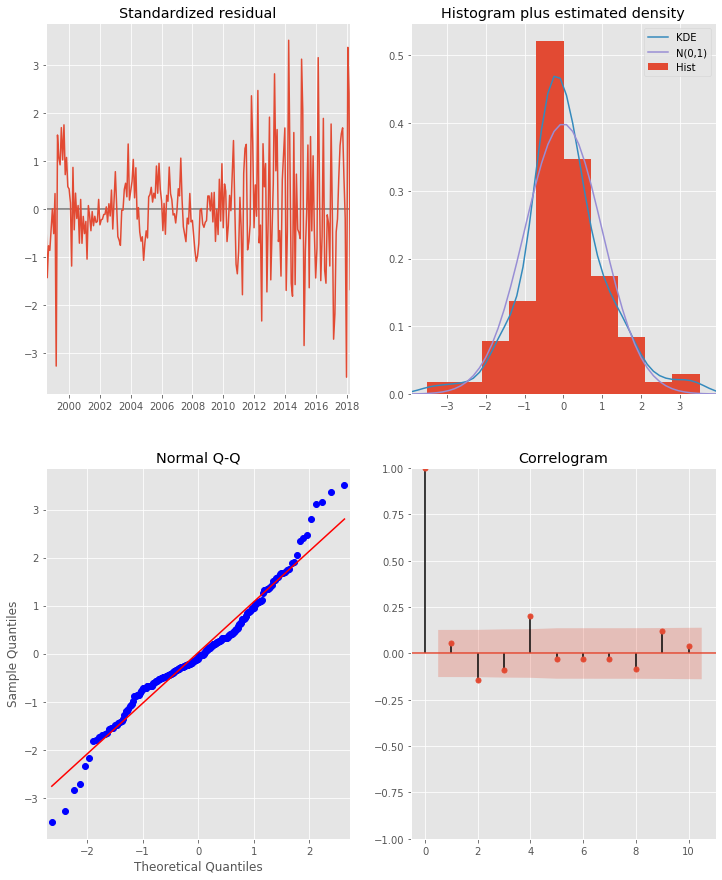

In [377]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

None of these plots look good, the patterns of the residuals changes, the KDE line is different from the N(0,1) line, the Q-Q residuals don't lie on the red line and there are many lag values that appear to be significant.

### Best fit with higher order model

I also ran a higher order loop earlier, which returned the following parameters. I have not included the calculation in this notebook, because it took a long time to run and returned over 700 lines. I will run this model and compare the parameters.

In [96]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 2, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1832.508
Date:                            Mon, 28 Oct 2019   AIC                           3679.016
Time:                                    01:24:34   BIC                           3702.512
Sample:                                04-01-1996   HQIC                          3688.513
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1657      0.193     -0.859      0.390      -0.544       0.212
ma.L1          1.2394      0.194   

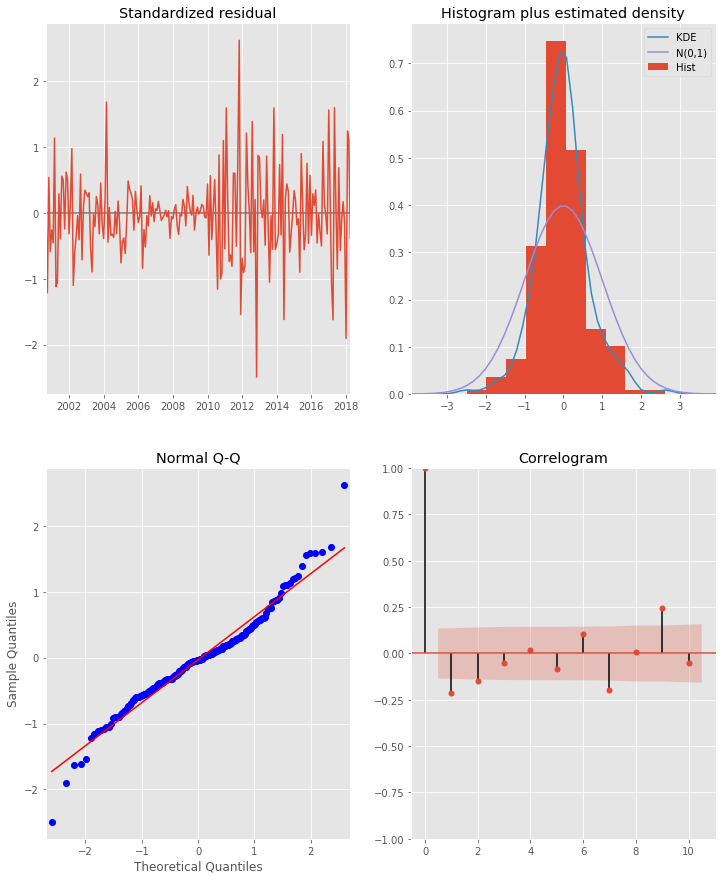

In [97]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

This model has a slightly supperior AIC. However the plots look worse than the loop model.


### Test Train Split

This point would be where we fit the model to a training data set, and then use the remaining portion of the data as a test. Once we are satisfied with the result we would refit the model to the entire database and forecast the future!

In the interests of time and space I have not done this in this project. The code would look something like:

In [98]:
# train = data.loc['1996-04':'2015-12']
# test = data.loc['2016-01':]

# output.fit(train)

### Get Predictions

In [99]:
df_zip = df_model['value'].resample('MS').mean()

#### One Step Ahead

First building a "one step ahead model" where each predicted value is based on the actual value immediately before it

In [100]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

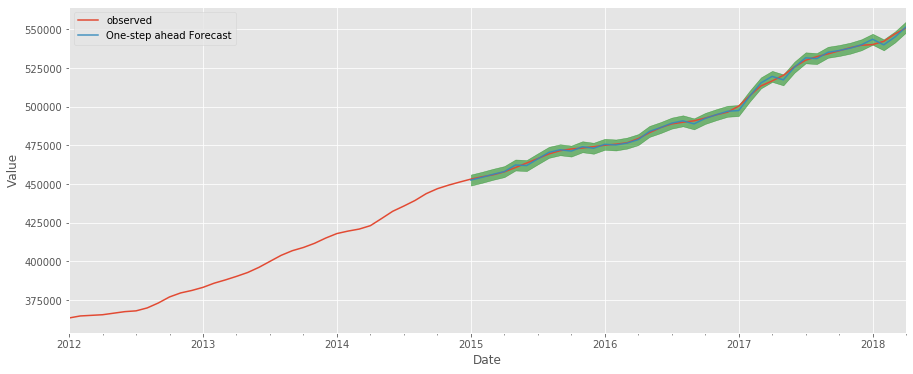

In [101]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = df_zip['2012':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

plt.show()

As expected, the "one step ahead" forecast is very close the actual value. We are only forecasting a month ahead each time, so this is not a realistic model

In [102]:
# Get the Real and predicted values
forecasted = pred.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 1851566.8


#### Dynamic Prediction

Now our forecast uses the previous predicted value to make its next prediction. In this case the forecast begins in 2015 

In [103]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

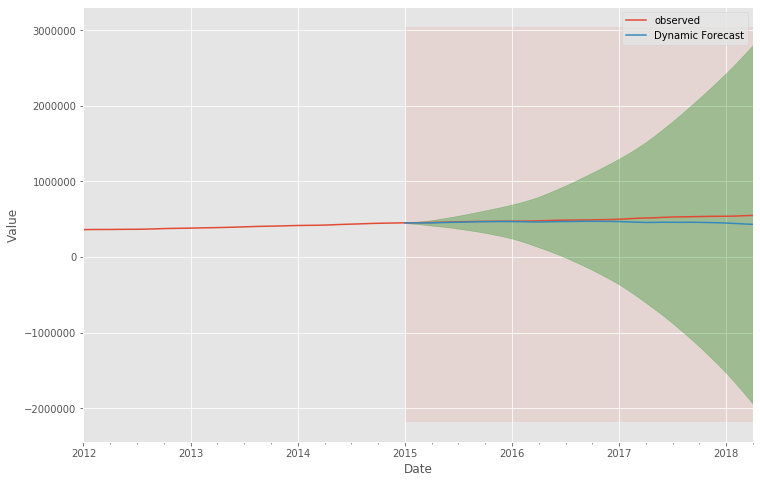

In [104]:
# Plot the dynamic forecast with confidence intervals as above
ax = df_zip['2012':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.legend()
plt.show()


This forecast diverges from the actual a lot more than the one step ahead model

In [105]:
# Extract the predicted and true values of our time series
forecasted = pred_dynamic.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 2475186003.82


The Mean Squared Error looks massive, because it is based on house values in hundreds of thousands of dollars, which are then squared. To see how it relates to housing prices we need to take the square root of it.

In [106]:
mse_sqrt = np.sqrt(mse)
print("The Square Root of the MSE at {} doesn't look as bad".format(round(mse_sqrt,0)))

The Square Root of the MSE at 49751.0 doesn't look as bad


### Forecasting the future

In [107]:
# Get the forecast 60 months ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

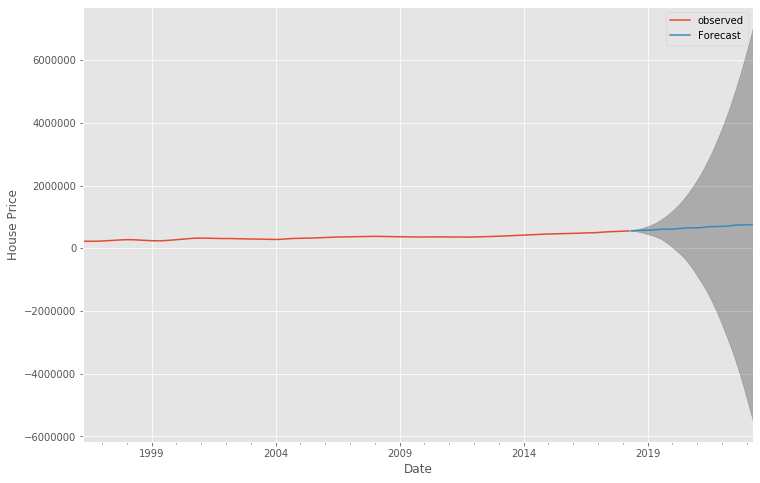

In [108]:
# Plot future predictions with confidence intervals

ax = df_zip.plot(label='observed', figsize=(12,8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Price')

plt.legend()
plt.show()

This forecast builds into the future. It shows the next 60 steps, or 5 years, or until 04-2023. There is a very large area under the confidence intervals - uncertainty increases dramatically after the first year or two.

#### Building a table of zip code forecasts

In [109]:
fcst = (output.forecast(steps=60).tail(1).sum())
actual = df_model.iloc[-1].value

In [110]:
fcst

761213.8969828534

In [111]:
actual

550900.0

In [112]:
zipdf2 = pd.DataFrame({"zip":[zip], 
                    "last_actual":[actual],
                    "last_fcst":fcst}) 

In [113]:
zipdf1 = zipdf1.append(zipdf2)

In [114]:
zipdf1

zip  last_actual      last_fcst
0  78660     242800.0  289337.630895
0  78704     550900.0  761213.896983

## Zip Code 78741

In [115]:
zip = 78741
df_model = df_78741

### ARIMA model

First test a simple ARIMA model, with no seasonality

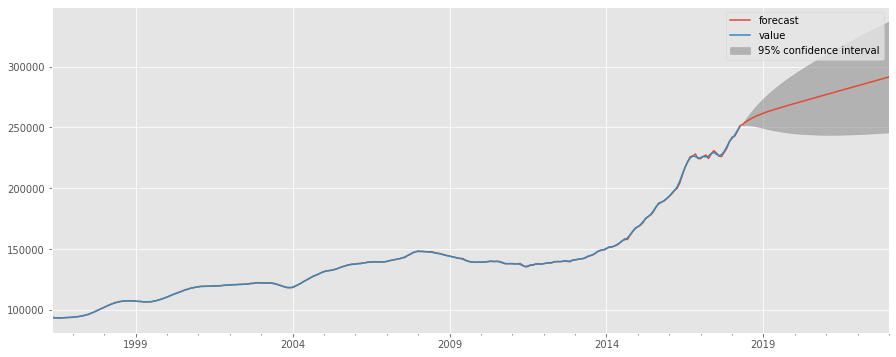

In [116]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast prices using an ARIMA(1,1,1) model
mod = ARIMA(df_model, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(end='2023-01-01')
plt.show()

In [117]:
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1964.391
Method:                       css-mle   S.D. of innovations            410.522
Date:                Mon, 28 Oct 2019   AIC                           3936.782
Time:                        01:24:39   BIC                           3951.086
Sample:                    05-01-1996   HQIC                          3942.530
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           604.1653    198.006      3.051      0.003     216.080     992.251
ar.L1.D.value     0.7922      0.039     20.363      0.000       0.716       0.868
ma.L1.D.value     0.6538      0.042     

In [118]:
print("The ARIMA model has an AIC of {}".format(round(res.aic,0)))

The ARIMA model has an AIC of 3937.0


Load the ARIMA model into SARIMAX, in order to access plot diagnosis

In [119]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_a = ARIMA_MODEL.fit()

print(output_a.summary())

                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1959.783
Date:                Mon, 28 Oct 2019   AIC                           3925.565
Time:                        01:24:39   BIC                           3936.271
Sample:                    04-01-1996   HQIC                          3929.868
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8498      0.020     43.536      0.000       0.812       0.888
ma.L1          0.5755      0.026     22.491      0.000       0.525       0.626
sigma2      1.705e+05   7161.574     23.802      0.0

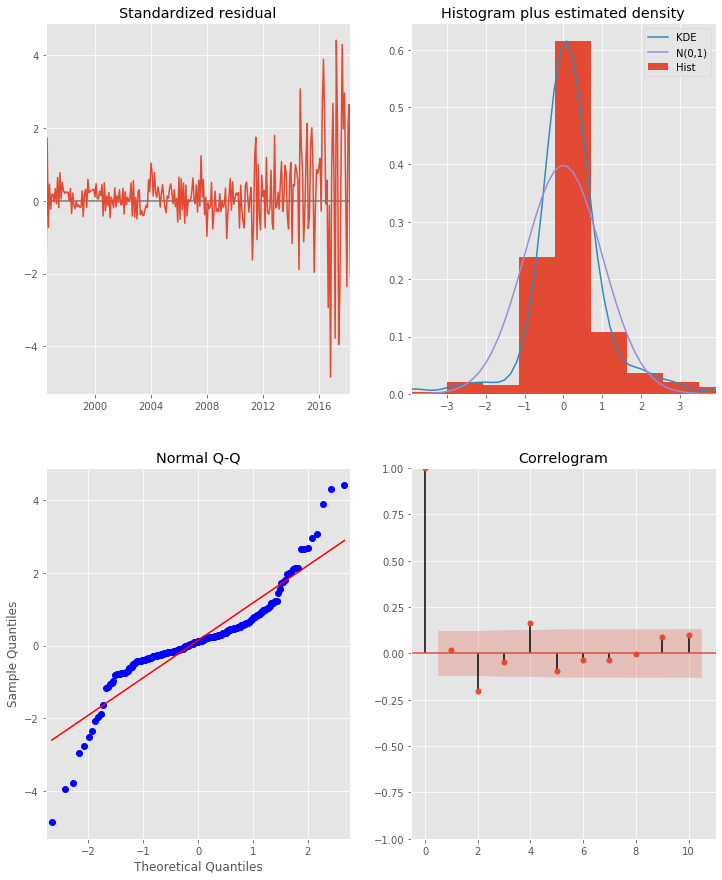

In [120]:
# Use plot_diagnostics with results calculated above.
output_a.plot_diagnostics(figsize=(12, 15))
plt.show()

None of these plots look good, the patterns of the residuals changes, the KDE line is different from the N(0,1) line, the Q-Q residuals don't lie on the red line and there are many lag values that appear to be significant.

### SARIMAX model

The code below tests different combinations of the model and returns an AIC value for each. From this we can select the best model

In [121]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [122]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_model,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7026.566118322364
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6550.469636690863
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5428.441217805433
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5178.527565076471
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5309.312723537693
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5278.52988364253
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5002.3275164185925
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =6400.412086719202
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6809.959396789718
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6760.15275181835
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5248.067405868978
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =7197.955958201316
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6486.978649697319
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6437.6202672237905
ARIMA (0, 0, 1) x (1

In [123]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]



pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           3657.78
Name: 59, dtype: object

In [124]:
print("The best model is ARIMA {}".format(ans_df.loc[ans_df['aic'].idxmin()].values))

The best model is ARIMA [(1, 1, 1) (0, 1, 1, 12) 3657.7779187903634]


### Model Output and Plot Diagnostics

### Best fit using loop

Now run the model using the parameters above

In [125]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1824.889
Date:                            Mon, 28 Oct 2019   AIC                           3657.778
Time:                                    01:25:21   BIC                           3671.667
Sample:                                04-01-1996   HQIC                          3663.375
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7682      0.024     32.459      0.000       0.722       0.815
ma.L1          0.6511      0.027   

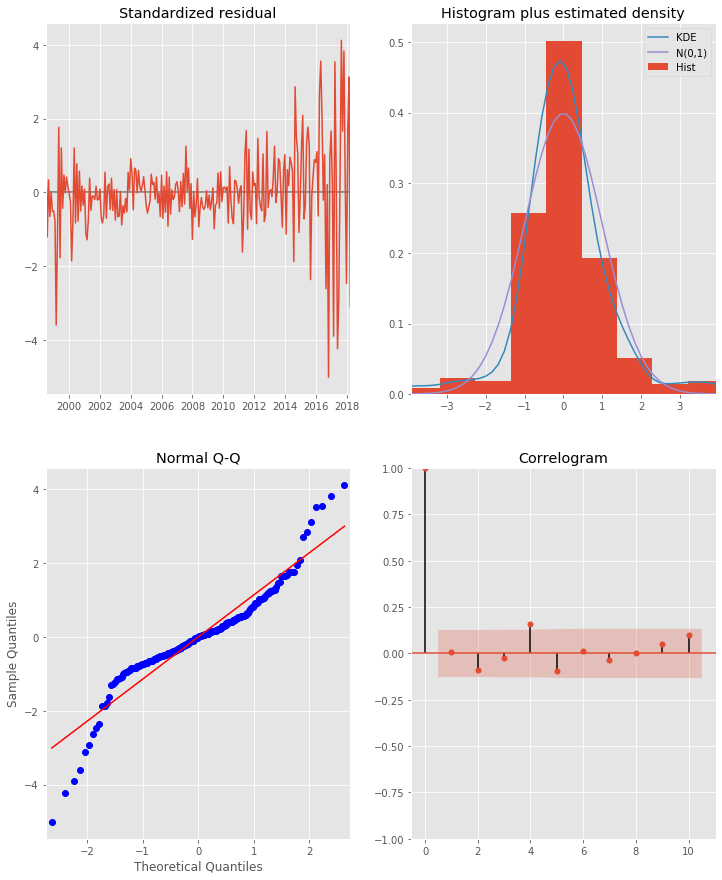

In [126]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

Although better than the simple model, all of these plots have issues

### Best fit with higher order model

I also ran a higher order loop earlier, which returned the following parameters. I have not included the calculation in this notebook, because it took a long time to run and returned over 700 lines. I will run this model and compare the parameters.

In [127]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 2, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1662.852
Date:                            Mon, 28 Oct 2019   AIC                           3339.704
Time:                                    01:25:39   BIC                           3363.200
Sample:                                04-01-1996   HQIC                          3349.200
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5091      0.102      4.984      0.000       0.309       0.709
ma.L1         -0.1083      0.096   

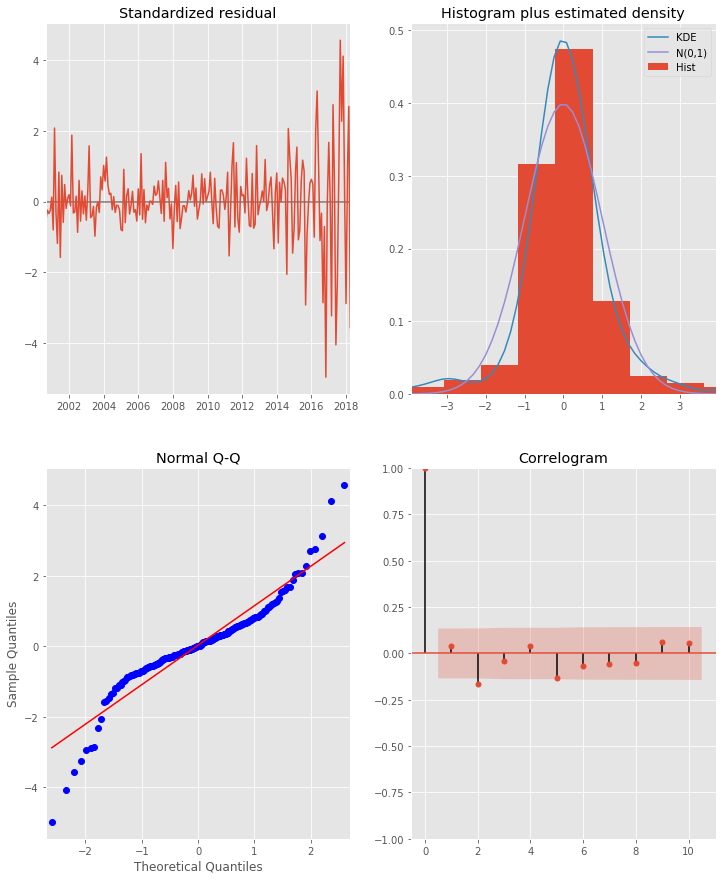

In [128]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

This model has a slightly supperior AIC. However it is has many issues with the diagnostic plots

### Test Train Split

This point would be where we fit the model to a training data set, and then use the remaining portion of the data as a test. Once we are satisfied with the result we would refit the model to the entire database and forecast the future!

In the interests of time and space I have not done this in this project. The code would look something like:

In [129]:
# train = data.loc['1996-04':'2015-12']
# test = data.loc['2016-01':]

# output.fit(train)

### Get Predictions

In [130]:
df_zip = df_model['value'].resample('MS').mean()

#### One Step Ahead

First building a "one step ahead model" where each predicted value is based on the actual value immediately before it

In [131]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

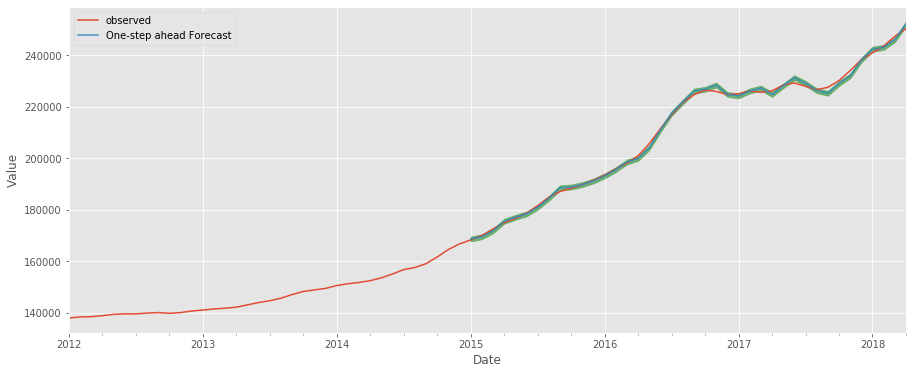

In [132]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = df_zip['2012':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

plt.show()

As expected, the "one step ahead" forecast is very close the actual value. We are only forecasting a month ahead each time, so this is not a realistic model

In [133]:
# Get the Real and predicted values
forecasted = pred.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 1178077.55


#### Dynamic Prediction

Now our forecast uses the previous predicted value to make its next prediction. In this case the forecast begins in 2015 

In [134]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

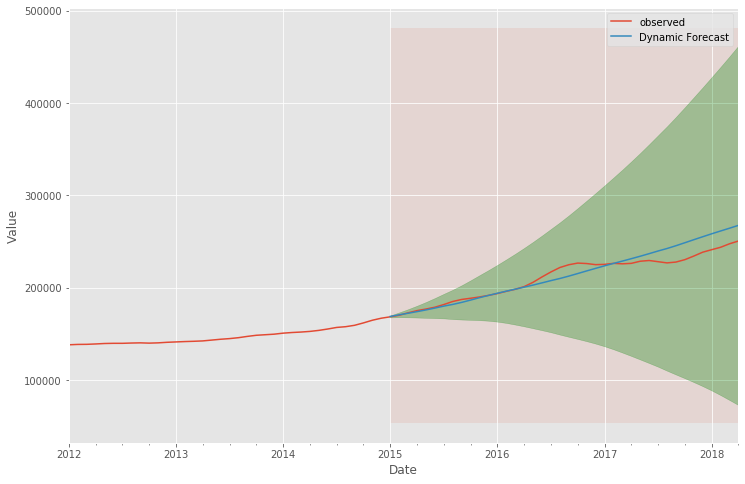

In [135]:
# Plot the dynamic forecast with confidence intervals as above
ax = df_zip['2012':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.legend()
plt.show()


This forecast diverges from the actual a lot more than the one step ahead model

In [136]:
# Extract the predicted and true values of our time series
forecasted = pred_dynamic.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 89806815.25


The Mean Squared Error looks massive, because it is based on house values in hundreds of thousands of dollars, which are then squared. To see how it relates to housing prices we need to take the square root of it.

In [137]:
mse_sqrt = np.sqrt(mse)
print("The Square Root of the MSE at {} doesn't look as bad".format(round(mse_sqrt,0)))

The Square Root of the MSE at 9477.0 doesn't look as bad


### Forecasting the future

In [138]:
# Get the forecast 60 months ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

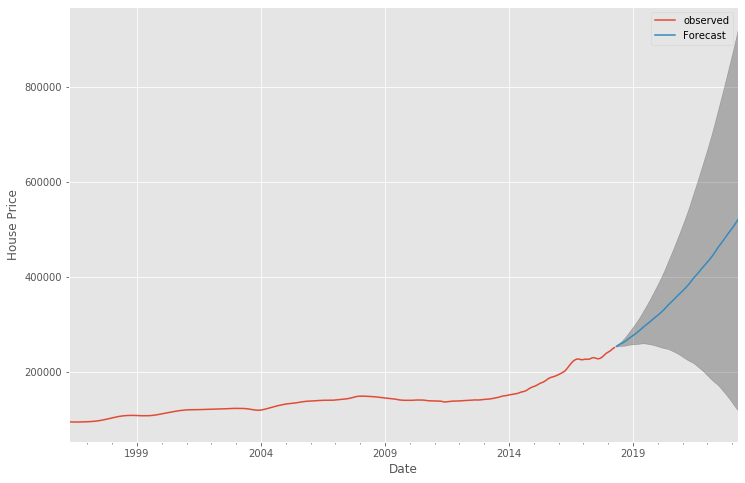

In [139]:
# Plot future predictions with confidence intervals

ax = df_zip.plot(label='observed', figsize=(12,8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Price')

plt.legend()
plt.show()

This forecast builds into the future. It shows the next 60 steps, or 5 years, or until 04-2023. There is a very large area under the confidence intervals - uncertainty increases dramatically after the first year or two.

#### Building a table of zip code forecasts

In [140]:
fcst = (output.forecast(steps=60).tail(1).sum())
actual = df_model.iloc[-1].value

In [141]:
fcst

521912.32511600736

In [142]:
actual

250400.0

In [143]:
zipdf2 = pd.DataFrame({"zip":[zip], 
                    "last_actual":[actual],
                    "last_fcst":fcst}) 

In [144]:
zipdf1 = zipdf1.append(zipdf2)

In [145]:
zipdf1

zip  last_actual      last_fcst
0  78660     242800.0  289337.630895
0  78704     550900.0  761213.896983
0  78741     250400.0  521912.325116

## Zip Code 78744

In [146]:
zip = 78744
df_model = df_78744

### ARIMA model

First test a simple ARIMA model, with no seasonality

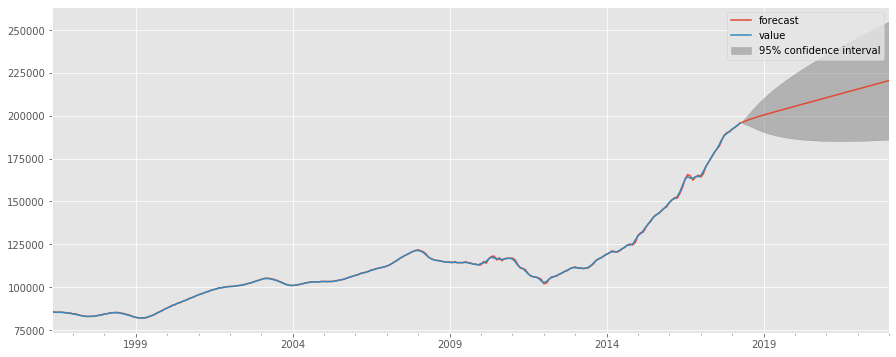

In [147]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast prices using an ARIMA(1,1,1) model
mod = ARIMA(df_model, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(end='2023-01-01')
plt.show()

In [148]:
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1938.532
Method:                       css-mle   S.D. of innovations            372.508
Date:                Mon, 28 Oct 2019   AIC                           3885.064
Time:                        01:25:44   BIC                           3899.368
Sample:                    05-01-1996   HQIC                          3890.812
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           417.3075    148.714      2.806      0.005     125.833     708.782
ar.L1.D.value     0.7620      0.042     18.282      0.000       0.680       0.844
ma.L1.D.value     0.5647      0.047     

In [149]:
print("The ARIMA model has an AIC of {}".format(round(res.aic,0)))

The ARIMA model has an AIC of 3885.0


Load the ARIMA model into SARIMAX, in order to access plot diagnosis

In [150]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_a = ARIMA_MODEL.fit()

print(output_a.summary())

                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1928.995
Date:                Mon, 28 Oct 2019   AIC                           3863.990
Time:                        01:25:44   BIC                           3874.695
Sample:                    04-01-1996   HQIC                          3868.293
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8136      0.027     29.660      0.000       0.760       0.867
ma.L1          0.5237      0.033     15.853      0.000       0.459       0.588
sigma2      1.489e+05   8257.052     18.030      0.0

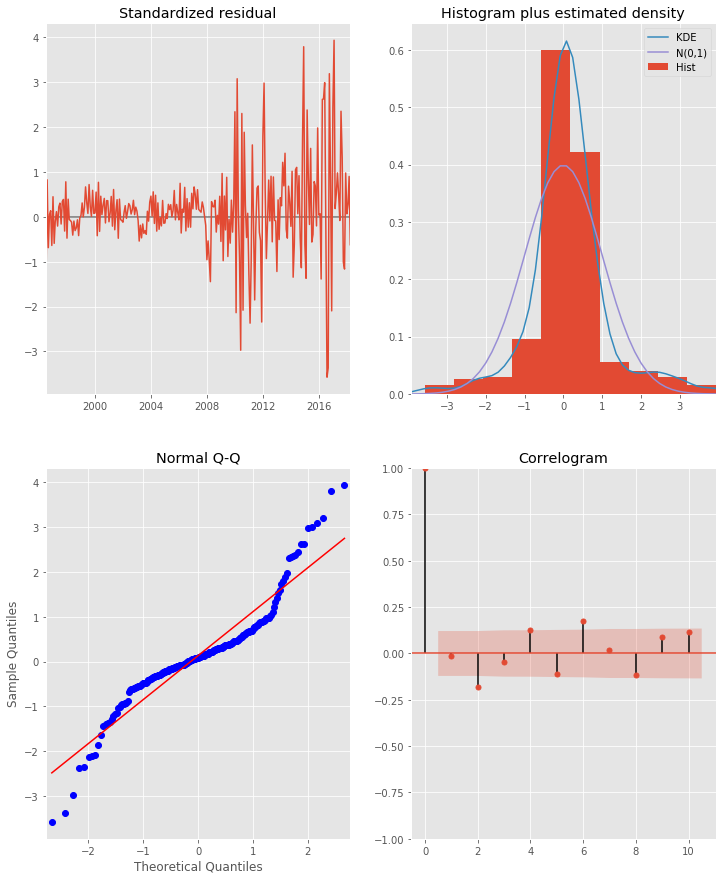

In [151]:
# Use plot_diagnostics with results calculated above.
output_a.plot_diagnostics(figsize=(12, 15))
plt.show()

None of these plots look good, the patterns of the residuals changes, the KDE line is different from the N(0,1) line, the Q-Q residuals don't lie on the red line and there are many lag values that appear to be significant.

### SARIMAX model

The code below tests different combinations of the model and returns an AIC value for each. From this we can select the best model

In [152]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [153]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_model,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =6905.445924587353
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6434.234033778473
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5324.721622602954
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5083.010798605655
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5233.708391029264
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5214.617376810453
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4926.53515774293
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =6092.430256142781
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6689.430809906541
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6629.615878503284
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5147.330357297595
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =4734.064214913862
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6370.635215212729
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6618.322821920194
ARIMA (0, 0, 1) x (1,

In [154]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]



pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           3594.05
Name: 59, dtype: object

In [155]:
print("The best model is ARIMA {}".format(ans_df.loc[ans_df['aic'].idxmin()].values))

The best model is ARIMA [(1, 1, 1) (0, 1, 1, 12) 3594.0546912462314]


### Model Output and Plot Diagnostics

### Best fit using loop

Now run the model using the parameters above

In [156]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1793.027
Date:                            Mon, 28 Oct 2019   AIC                           3594.055
Time:                                    01:26:27   BIC                           3607.944
Sample:                                04-01-1996   HQIC                          3599.652
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7478      0.030     24.910      0.000       0.689       0.807
ma.L1          0.5704      0.028   

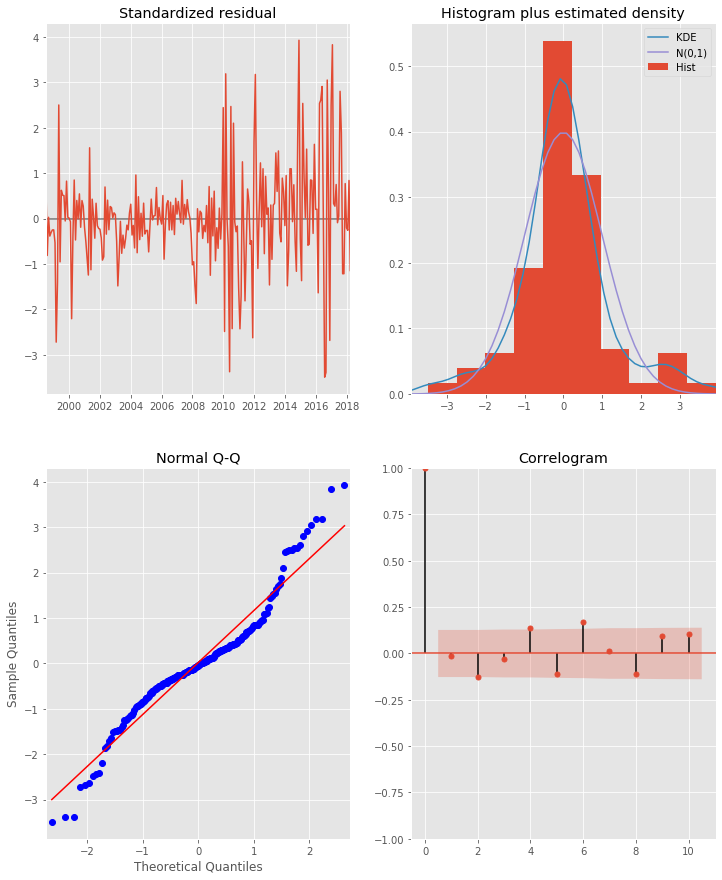

In [157]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

I have concerns with the residuals in all of these plots

### Best fit with higher order model

I also ran a higher order loop earlier, which returned the following parameters. I have not included the calculation in this notebook, because it took a long time to run and returned over 700 lines. I will run this model and compare the parameters.

In [158]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 2, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1630.963
Date:                            Mon, 28 Oct 2019   AIC                           3275.926
Time:                                    01:26:46   BIC                           3299.422
Sample:                                04-01-1996   HQIC                          3285.422
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5541      0.083      6.705      0.000       0.392       0.716
ma.L1         -0.2670      0.081   

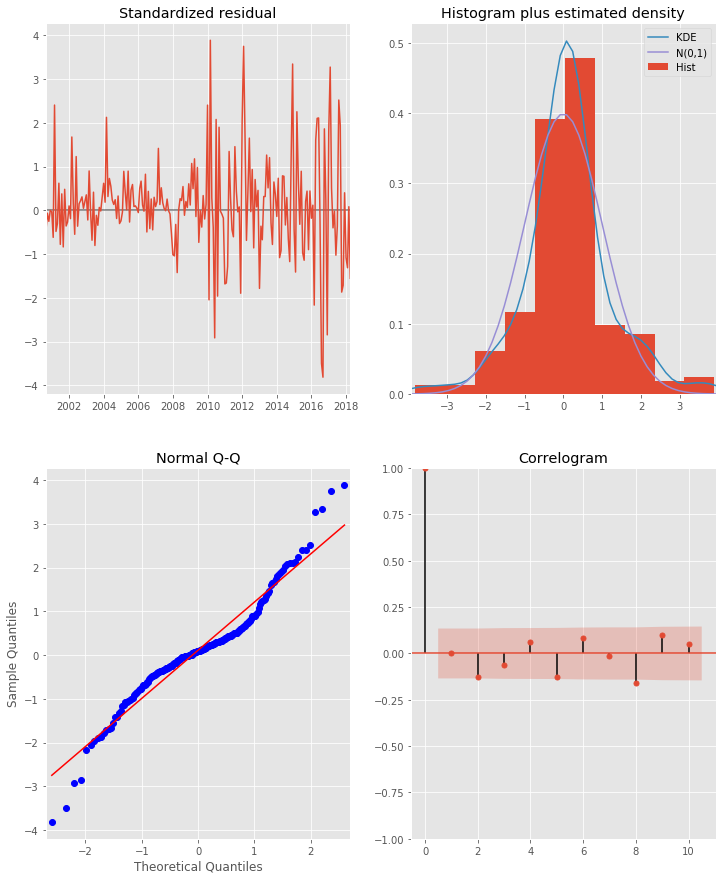

In [159]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

This model has a slightly supperior AIC, and slightly improved plot. However all of these plot still have issues


### Test Train Split

This point would be where we fit the model to a training data set, and then use the remaining portion of the data as a test. Once we are satisfied with the result we would refit the model to the entire database and forecast the future!

In the interests of time and space I have not done this in this project. The code would look something like:

In [160]:
# train = data.loc['1996-04':'2015-12']
# test = data.loc['2016-01':]

# output.fit(train)

### Get Predictions

In [161]:
df_zip = df_model['value'].resample('MS').mean()

#### One Step Ahead

First building a "one step ahead model" where each predicted value is based on the actual value immediately before it

In [162]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

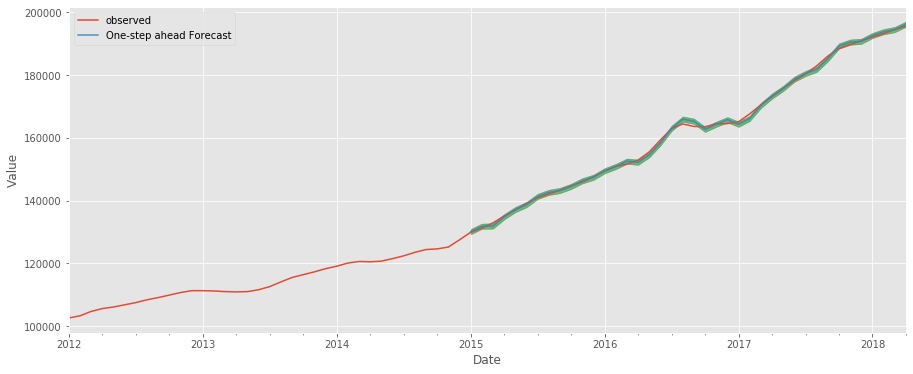

In [163]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = df_zip['2012':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

plt.show()

As expected, the "one step ahead" forecast is very close the actual value. We are only forecasting a month ahead each time, so this is not a realistic model

In [164]:
# Get the Real and predicted values
forecasted = pred.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 502425.43


#### Dynamic Prediction

Now our forecast uses the previous predicted value to make its next prediction. In this case the forecast begins in 2015 

In [165]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

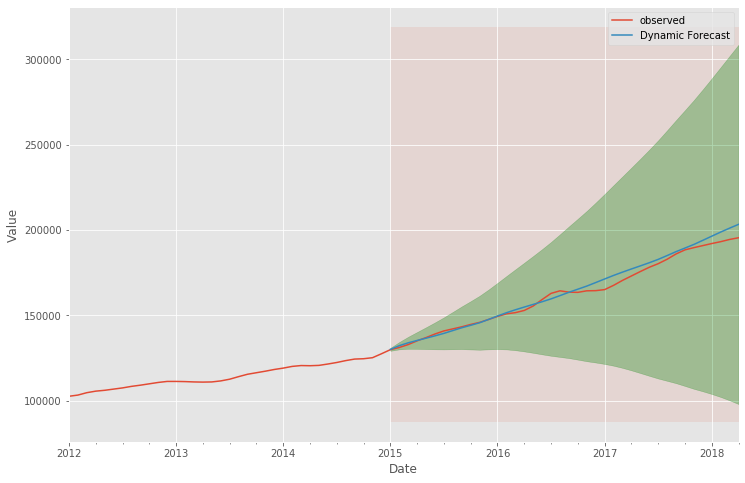

In [166]:
# Plot the dynamic forecast with confidence intervals as above
ax = df_zip['2012':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.legend()
plt.show()


This forecast diverges from the actual a lot more than the one step ahead model

In [167]:
# Extract the predicted and true values of our time series
forecasted = pred_dynamic.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 9566192.58


The Mean Squared Error looks massive, because it is based on house values in hundreds of thousands of dollars, which are then squared. To see how it relates to housing prices we need to take the square root of it.

In [168]:
mse_sqrt = np.sqrt(mse)
print("The Square Root of the MSE at {} doesn't look as bad".format(round(mse_sqrt,0)))

The Square Root of the MSE at 3093.0 doesn't look as bad


### Forecasting the future

In [169]:
# Get the forecast 60 months ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

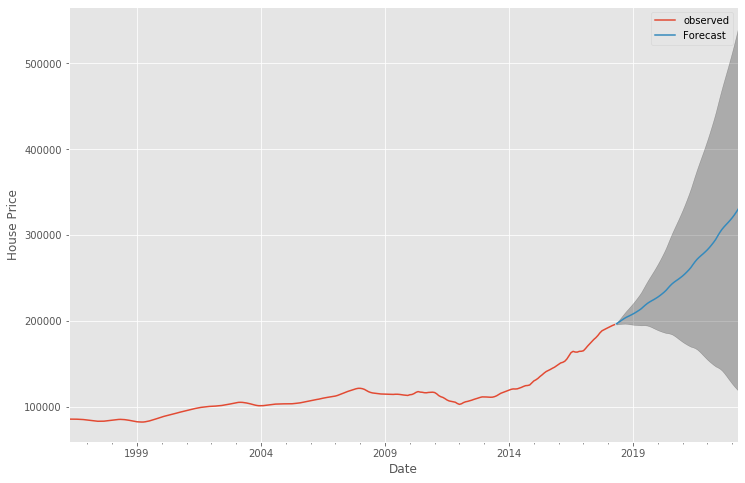

In [170]:
# Plot future predictions with confidence intervals

ax = df_zip.plot(label='observed', figsize=(12,8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Price')

plt.legend()
plt.show()

This forecast builds into the future. It shows the next 60 steps, or 5 years, or until 04-2023. There is a very large area under the confidence intervals - uncertainty increases dramatically after the first year or two.

#### Building a table of zip code forecasts

In [171]:
fcst = (output.forecast(steps=60).tail(1).sum())
actual = df_model.iloc[-1].value

In [172]:
fcst

330606.08501931845

In [173]:
actual

195500.0

In [174]:
zipdf2 = pd.DataFrame({"zip":[zip], 
                    "last_actual":[actual],
                    "last_fcst":fcst}) 

In [175]:
zipdf1 = zipdf1.append(zipdf2)

In [176]:
zipdf1

zip  last_actual      last_fcst
0  78660     242800.0  289337.630895
0  78704     550900.0  761213.896983
0  78741     250400.0  521912.325116
0  78744     195500.0  330606.085019

## Zip Code 78745

In [177]:
zip = 78745
df_model = df_78745

### ARIMA model

First test a simple ARIMA model, with no seasonality

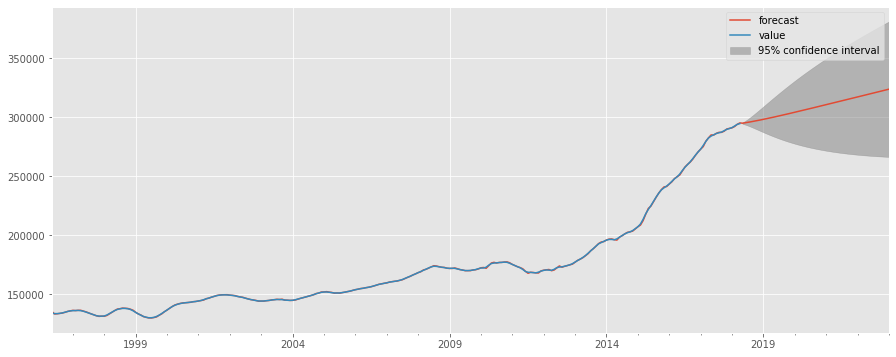

In [178]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast prices using an ARIMA(1,1,1) model
mod = ARIMA(df_model, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(end='2023-01-01')
plt.show()

In [179]:
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1870.617
Method:                       css-mle   S.D. of innovations            287.417
Date:                Mon, 28 Oct 2019   AIC                           3749.233
Time:                        01:26:53   BIC                           3763.537
Sample:                    05-01-1996   HQIC                          3754.981
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           548.1476    263.472      2.080      0.038      31.752    1064.543
ar.L1.D.value     0.8924      0.028     31.957      0.000       0.838       0.947
ma.L1.D.value     0.6516      0.041     

In [180]:
print("The ARIMA model has an AIC of {}".format(round(res.aic,0)))

The ARIMA model has an AIC of 3749.0


Load the ARIMA model into SARIMAX, in order to access plot diagnosis

In [181]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_a = ARIMA_MODEL.fit()

print(output_a.summary())

                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1862.312
Date:                Mon, 28 Oct 2019   AIC                           3730.624
Time:                        01:26:54   BIC                           3741.329
Sample:                    04-01-1996   HQIC                          3734.926
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9237      0.016     59.207      0.000       0.893       0.954
ma.L1          0.5767      0.037     15.530      0.000       0.504       0.649
sigma2      8.101e+04   4318.905     18.758      0.0

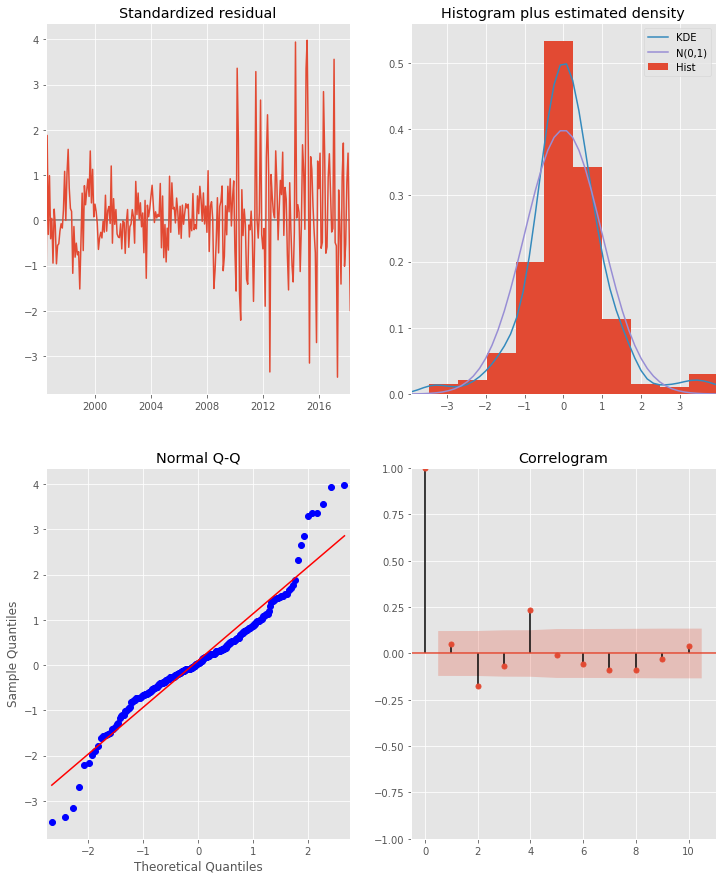

In [182]:
# Use plot_diagnostics with results calculated above.
output_a.plot_diagnostics(figsize=(12, 15))
plt.show()

None of these plots look good, the patterns of the residuals changes, the KDE line is different from the N(0,1) line, the Q-Q residuals don't lie on the red line and there are many lag values that appear to be significant.

### SARIMAX model

The code below tests different combinations of the model and returns an AIC value for each. From this we can select the best model

In [183]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [184]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_model,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7134.4185566193755
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6651.911660954713
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5483.176604408212
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5234.380454567025
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5351.580178355396
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5333.3324787776
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5062.380456259932
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5036.671930332584
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6917.535741441509
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6889.30094071635
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5308.799898794001
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =7153.987881692512
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6589.854489373733
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6539.6890818363345
ARIMA (0, 0, 1) x (1,

In [185]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]



pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic            3478.5
Name: 59, dtype: object

In [186]:
print("The best model is ARIMA {}".format(ans_df.loc[ans_df['aic'].idxmin()].values))

The best model is ARIMA [(1, 1, 1) (0, 1, 1, 12) 3478.4990719833077]


### Model Output and Plot Diagnostics

### Best fit using loop

Now run the model using the parameters above

In [187]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1735.250
Date:                            Mon, 28 Oct 2019   AIC                           3478.499
Time:                                    01:27:41   BIC                           3492.388
Sample:                                04-01-1996   HQIC                          3484.097
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8698      0.020     42.592      0.000       0.830       0.910
ma.L1          0.6485      0.035   

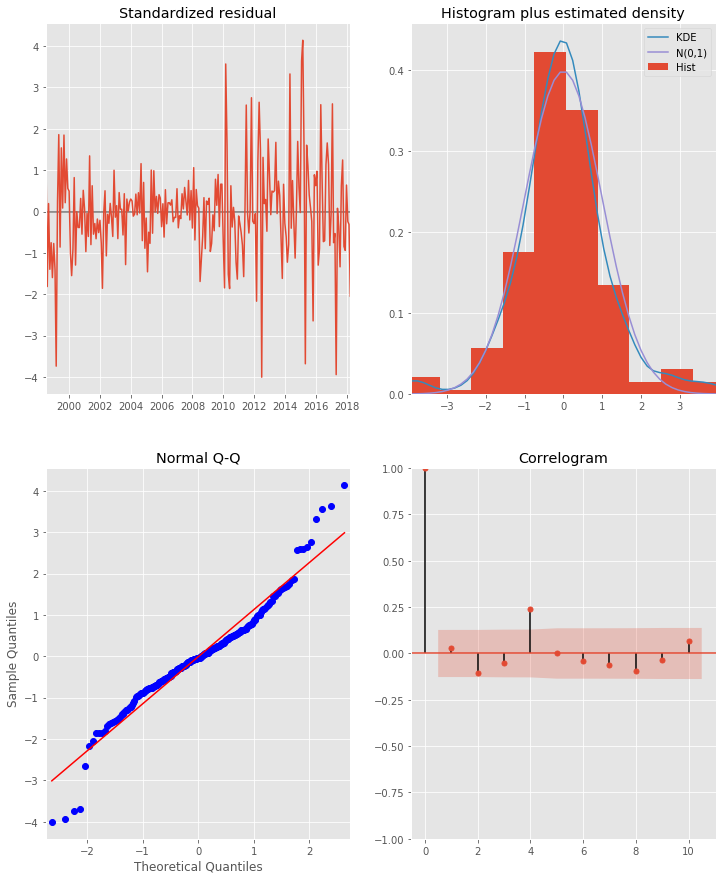

In [188]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

These plots are improved, although you can see issues in all of them, the residuals are getting closer to normal

### Best fit with higher order model

I also ran a higher order loop earlier, which returned the following parameters. I have not included the calculation in this notebook, because it took a long time to run and returned over 700 lines. I will run this model and compare the parameters.

In [189]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 2, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1572.326
Date:                            Mon, 28 Oct 2019   AIC                           3158.651
Time:                                    01:27:59   BIC                           3182.147
Sample:                                04-01-1996   HQIC                          3168.148
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4895      0.148      3.297      0.001       0.199       0.780
ma.L1         -0.0304      0.144   

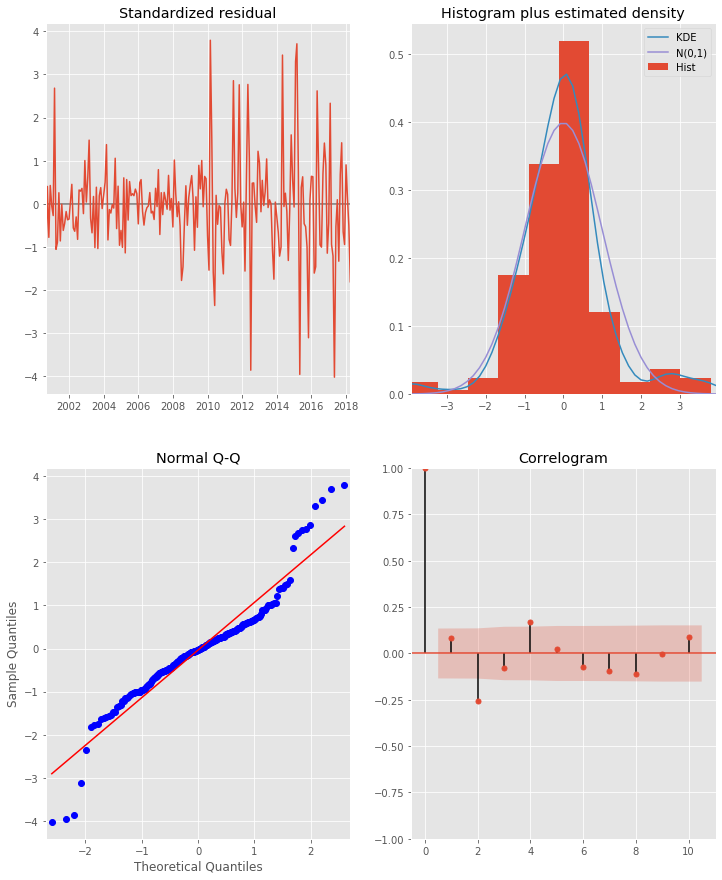

In [190]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

This model has a slightly supperior AIC. However the diagnostic plots have not improved from the loop model


### Test Train Split

This point would be where we fit the model to a training data set, and then use the remaining portion of the data as a test. Once we are satisfied with the result we would refit the model to the entire database and forecast the future!

In the interests of time and space I have not done this in this project. The code would look something like:

In [191]:
# train = data.loc['1996-04':'2015-12']
# test = data.loc['2016-01':]

# output.fit(train)

### Get Predictions

In [192]:
df_zip = df_model['value'].resample('MS').mean()

#### One Step Ahead

First building a "one step ahead model" where each predicted value is based on the actual value immediately before it

In [193]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

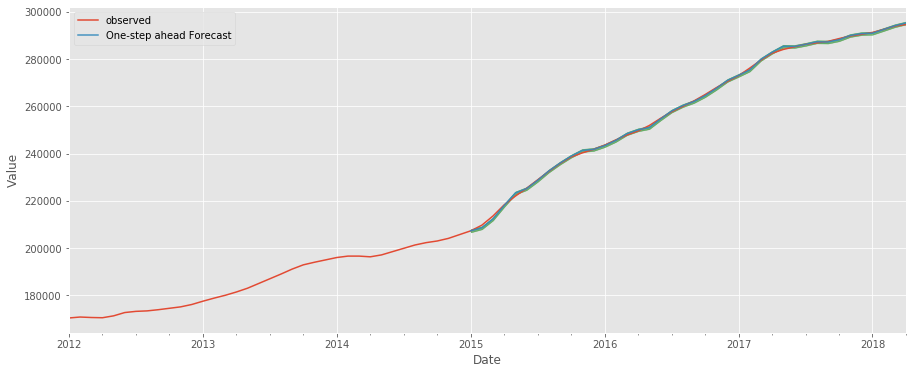

In [194]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = df_zip['2012':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

plt.show()

As expected, the "one step ahead" forecast is very close the actual value. We are only forecasting a month ahead each time, so this is not a realistic model

In [195]:
# Get the Real and predicted values
forecasted = pred.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 299578.07


#### Dynamic Prediction

Now our forecast uses the previous predicted value to make its next prediction. In this case the forecast begins in 2015 

In [196]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

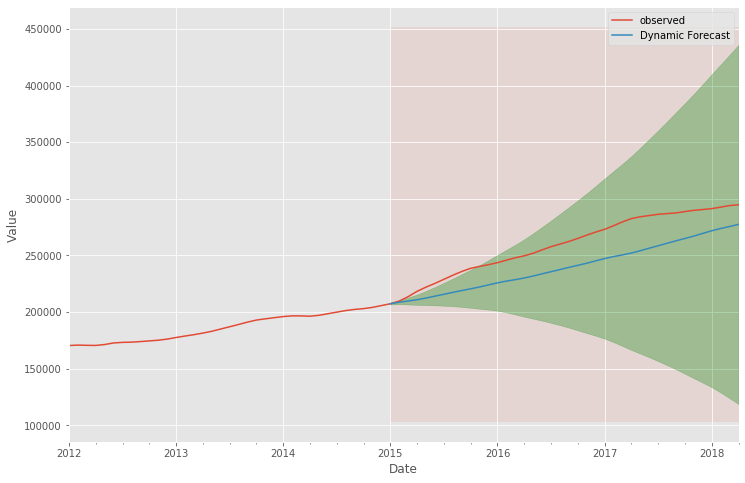

In [197]:
# Plot the dynamic forecast with confidence intervals as above
ax = df_zip['2012':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.legend()
plt.show()


This forecast diverges from the actual a lot more than the one step ahead model

In [198]:
# Extract the predicted and true values of our time series
forecasted = pred_dynamic.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 436230233.26


The Mean Squared Error looks massive, because it is based on house values in hundreds of thousands of dollars, which are then squared. To see how it relates to housing prices we need to take the square root of it.

In [199]:
mse_sqrt = np.sqrt(mse)
print("The Square Root of the MSE at {} doesn't look as bad".format(round(mse_sqrt,0)))

The Square Root of the MSE at 20886.0 doesn't look as bad


### Forecasting the future

In [200]:
# Get the forecast 60 months ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

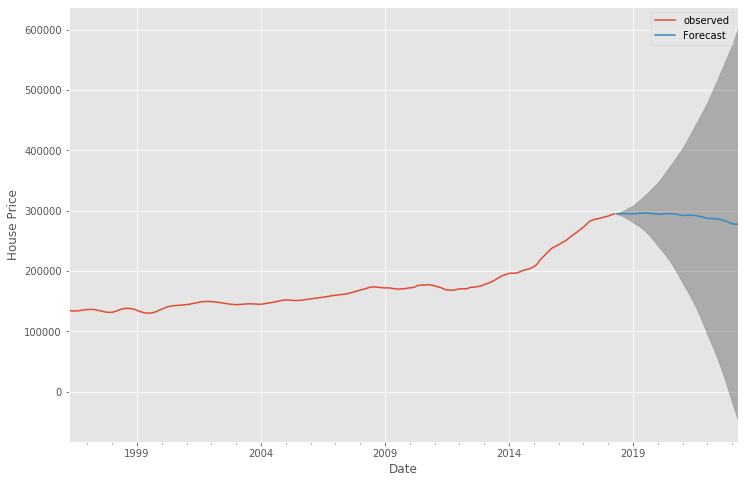

In [201]:
# Plot future predictions with confidence intervals

ax = df_zip.plot(label='observed', figsize=(12,8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Price')

plt.legend()
plt.show()

This forecast builds into the future. It shows the next 60 steps, or 5 years, or until 04-2023. There is a very large area under the confidence intervals - uncertainty increases dramatically after the first year or two.

#### Building a table of zip code forecasts

In [202]:
fcst = (output.forecast(steps=60).tail(1).sum())
actual = df_model.iloc[-1].value

In [203]:
fcst

277517.4585523704

In [204]:
actual

294700.0

In [205]:
zipdf2 = pd.DataFrame({"zip":[zip], 
                    "last_actual":[actual],
                    "last_fcst":fcst}) 

In [206]:
zipdf1 = zipdf1.append(zipdf2)

In [207]:
zipdf1

zip  last_actual      last_fcst
0  78660     242800.0  289337.630895
0  78704     550900.0  761213.896983
0  78741     250400.0  521912.325116
0  78744     195500.0  330606.085019
0  78745     294700.0  277517.458552

## Zip Code 78748

In [208]:
zip = 78748
df_model = df_78748

### ARIMA model

First test a simple ARIMA model, with no seasonality

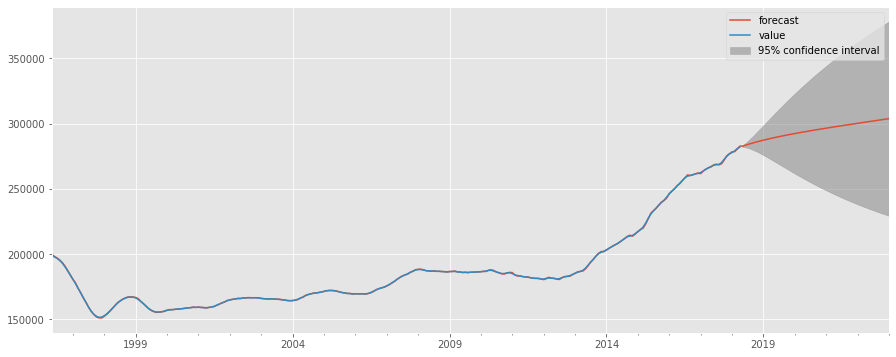

In [209]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast prices using an ARIMA(1,1,1) model
mod = ARIMA(df_model, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(end='2023-01-01')
plt.show()

In [210]:
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1861.103
Method:                       css-mle   S.D. of innovations            277.066
Date:                Mon, 28 Oct 2019   AIC                           3730.207
Time:                        01:28:07   BIC                           3744.511
Sample:                    05-01-1996   HQIC                          3735.955
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           288.6865    362.881      0.796      0.427    -422.548     999.921
ar.L1.D.value     0.9267      0.023     41.089      0.000       0.882       0.971
ma.L1.D.value     0.6353      0.042     

In [211]:
print("The ARIMA model has an AIC of {}".format(round(res.aic,0)))

The ARIMA model has an AIC of 3730.0


Load the ARIMA model into SARIMAX, in order to access plot diagnosis

In [212]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_a = ARIMA_MODEL.fit()

print(output_a.summary())

                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1859.698
Date:                Mon, 28 Oct 2019   AIC                           3725.396
Time:                        01:28:09   BIC                           3736.101
Sample:                    04-01-1996   HQIC                          3729.699
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9404      0.017     55.894      0.000       0.907       0.973
ma.L1          0.4977      0.022     22.344      0.000       0.454       0.541
sigma2      7.859e+04   5531.216     14.209      0.0

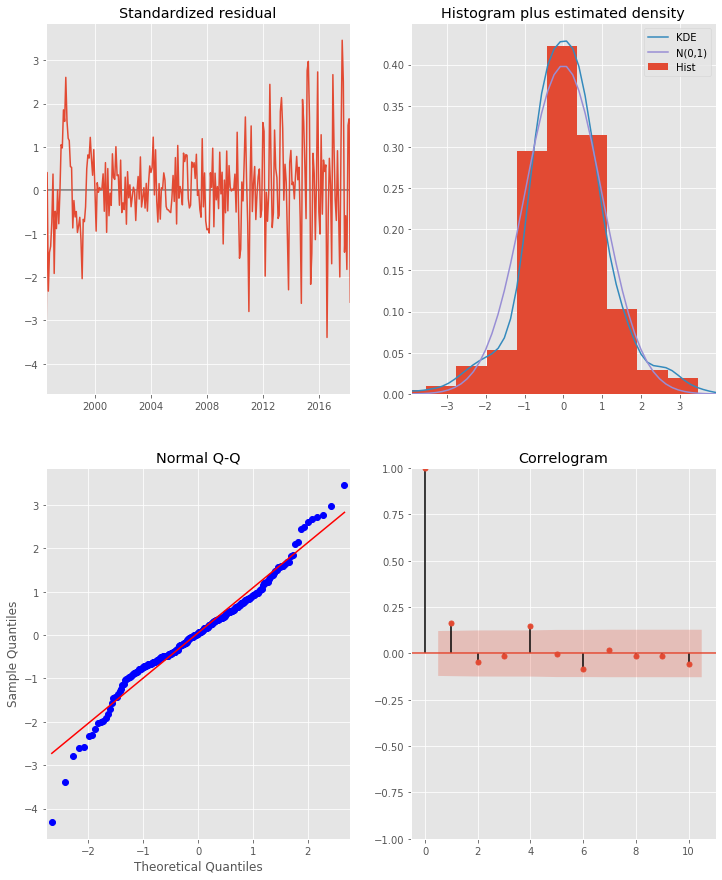

In [213]:
# Use plot_diagnostics with results calculated above.
output_a.plot_diagnostics(figsize=(12, 15))
plt.show()

These 4 plots give us a measure of how good the model is, by focussing on the residuals - the difference between the predictions and the true values. In this case they are pretty good.
    

### SARIMAX model

The code below tests different combinations of the model and returns an AIC value for each. From this we can select the best model

In [214]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [215]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_model,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7170.32694824091
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6684.046939756087
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5469.880580866715
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5133.137523507623
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5462.290506259319
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5334.639776362512
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5106.955889254115
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =6424.040851375228
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6953.325049438383
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6593.352994734716
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5293.071444810149
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =7324.753341929543
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6623.001099455134
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6979.467452091514
ARIMA (0, 0, 1) x (1,

In [216]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]



pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           3453.74
Name: 59, dtype: object

In [217]:
print("The best model is ARIMA {}".format(ans_df.loc[ans_df['aic'].idxmin()].values))

The best model is ARIMA [(1, 1, 1) (0, 1, 1, 12) 3453.7426095037417]


### Model Output and Plot Diagnostics

### Best fit using loop

Now run the model using the parameters above

In [218]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1722.871
Date:                            Mon, 28 Oct 2019   AIC                           3453.743
Time:                                    01:28:59   BIC                           3467.632
Sample:                                04-01-1996   HQIC                          3459.340
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8400      0.024     34.330      0.000       0.792       0.888
ma.L1          0.6102      0.038   

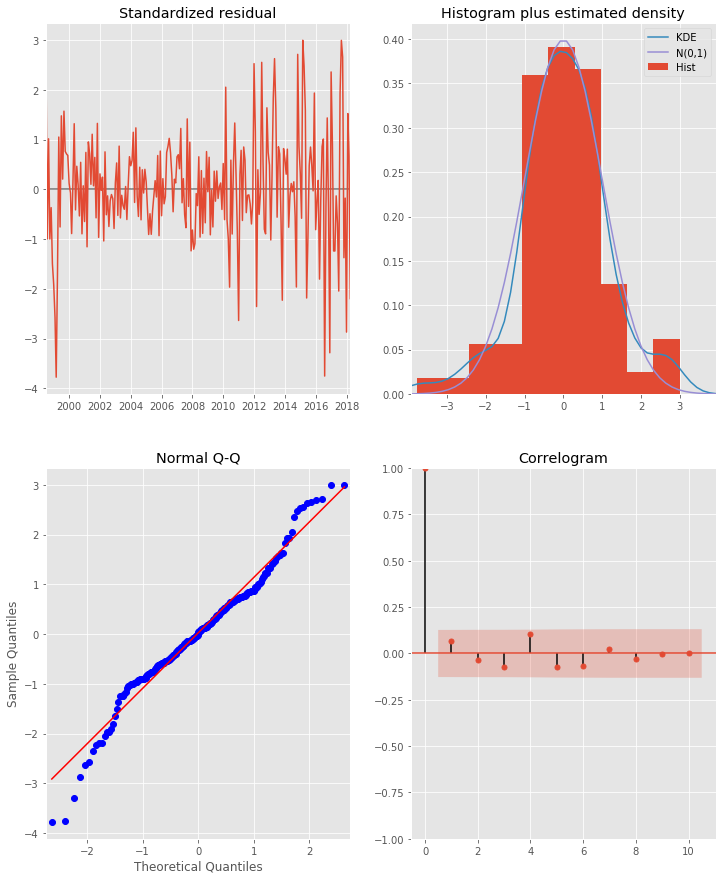

In [219]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

Residual plots look good

### Best fit with higher order model

I also ran a higher order loop earlier, which returned the following parameters. I have not included the calculation in this notebook, because it took a long time to run and returned over 700 lines. I will run this model and compare the parameters.

In [220]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 2, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1588.230
Date:                            Mon, 28 Oct 2019   AIC                           3190.461
Time:                                    01:29:19   BIC                           3213.957
Sample:                                04-01-1996   HQIC                          3199.957
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7486      0.107      6.994      0.000       0.539       0.958
ma.L1         -0.3337      0.102   

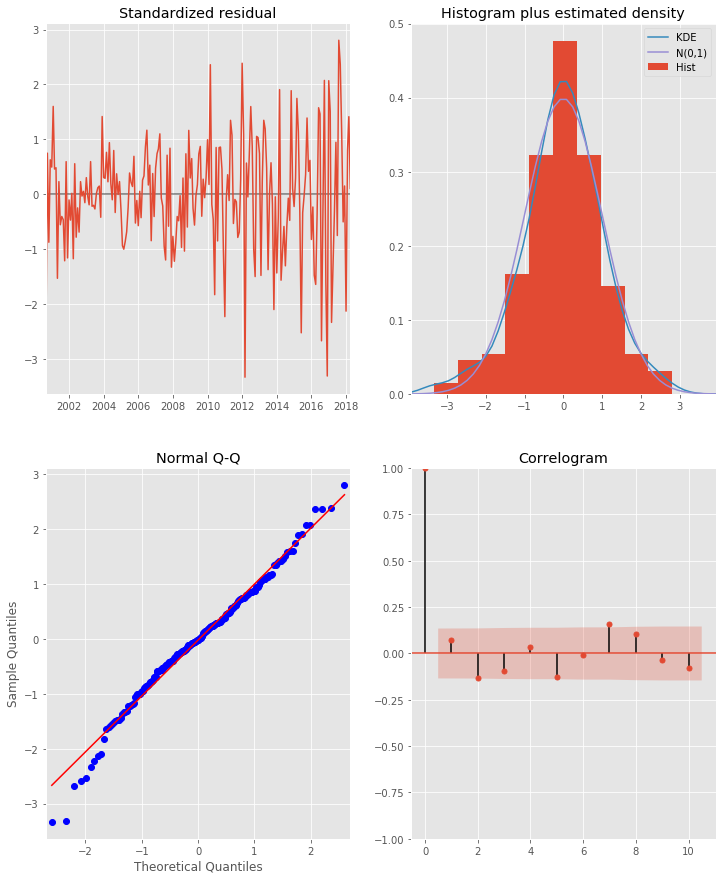

In [221]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

This model has a slightly supperior AIC. However it is more complicated and has a higher order of differencing, so it is debatable whether it is a better more. 

### Test Train Split

This point would be where we fit the model to a training data set, and then use the remaining portion of the data as a test. Once we are satisfied with the result we would refit the model to the entire database and forecast the future!

In the interests of time and space I have not done this in this project. The code would look something like:

In [222]:
# train = data.loc['1996-04':'2015-12']
# test = data.loc['2016-01':]

# output.fit(train)

### Get Predictions

In [223]:
df_zip = df_model['value'].resample('MS').mean()

#### One Step Ahead

First building a "one step ahead model" where each predicted value is based on the actual value immediately before it

In [224]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

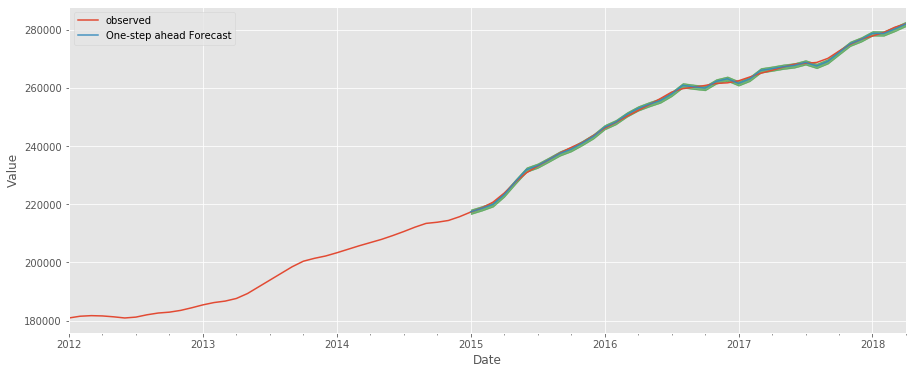

In [225]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = df_zip['2012':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

plt.show()

As expected, the "one step ahead" forecast is very close the actual value. We are only forecasting a month ahead each time, so this is not a realistic model

In [226]:
# Get the Real and predicted values
forecasted = pred.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 392347.63


#### Dynamic Prediction

Now our forecast uses the previous predicted value to make its next prediction. In this case the forecast begins in 2015 

In [227]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

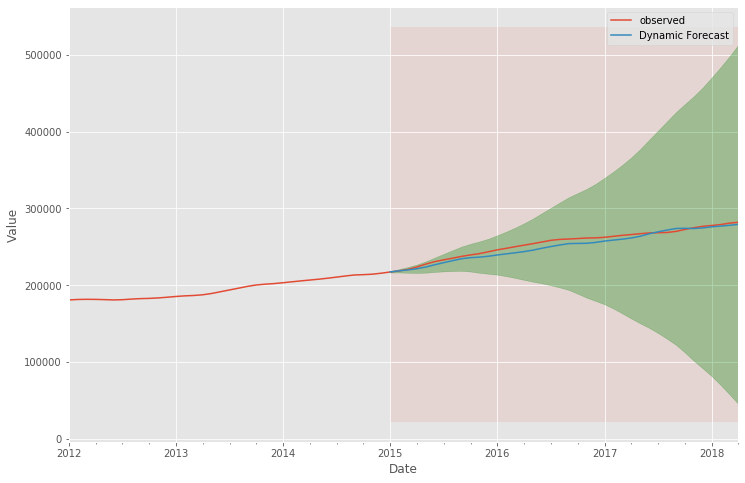

In [228]:
# Plot the dynamic forecast with confidence intervals as above
ax = df_zip['2012':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.legend()
plt.show()


This forecast diverges from the actual a lot more than the one step ahead model

In [229]:
# Extract the predicted and true values of our time series
forecasted = pred_dynamic.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 23567198.55


The Mean Squared Error looks massive, because it is based on house values in hundreds of thousands of dollars, which are then squared. To see how it relates to housing prices we need to take the square root of it.

In [230]:
mse_sqrt = np.sqrt(mse)
print("The Square Root of the MSE at {} doesn't look as bad".format(round(mse_sqrt,0)))

The Square Root of the MSE at 4855.0 doesn't look as bad


### Forecasting the future

In [231]:
# Get the forecast 60 months ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

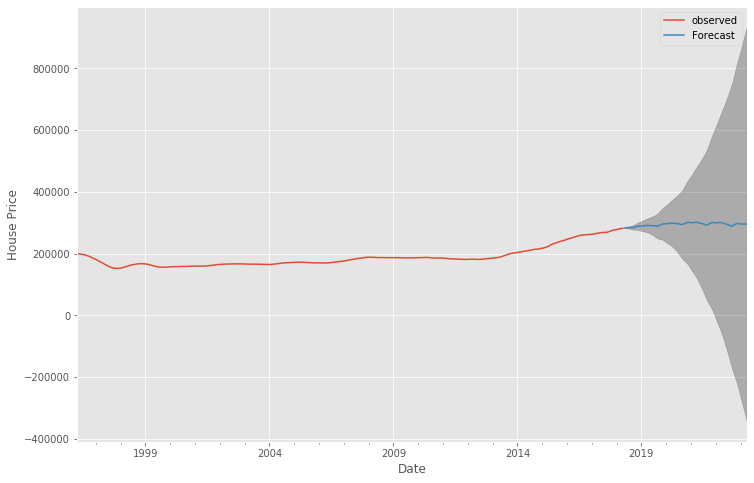

In [232]:
# Plot future predictions with confidence intervals

ax = df_zip.plot(label='observed', figsize=(12,8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Price')

plt.legend()
plt.show()

This forecast builds into the future. It shows the next 60 steps, or 5 years, or until 04-2023. There is a very large area under the confidence intervals - uncertainty increases dramatically after the first year or two.

#### Building a table of zip code forecasts

In [233]:
fcst = (output.forecast(steps=60).tail(1).sum())
actual = df_model.iloc[-1].value

In [234]:
fcst

294581.0451132017

In [235]:
actual

282000.0

In [236]:
zipdf2 = pd.DataFrame({"zip":[zip], 
                    "last_actual":[actual],
                    "last_fcst":fcst}) 

In [237]:
zipdf1 = zipdf1.append(zipdf2)

In [238]:
zipdf1

zip  last_actual      last_fcst
0  78660     242800.0  289337.630895
0  78704     550900.0  761213.896983
0  78741     250400.0  521912.325116
0  78744     195500.0  330606.085019
0  78745     294700.0  277517.458552
0  78748     282000.0  294581.045113

## Zip Code 78749

In [239]:
zip = 78749
df_model = df_78749

### ARIMA model

First test a simple ARIMA model, with no seasonality

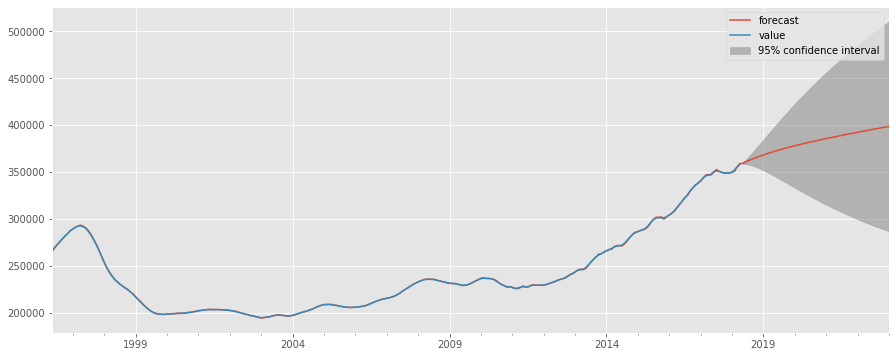

In [240]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast prices using an ARIMA(1,1,1) model
mod = ARIMA(df_model, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(end='2023-01-01')
plt.show()

In [241]:
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1946.427
Method:                       css-mle   S.D. of innovations            382.629
Date:                Mon, 28 Oct 2019   AIC                           3900.853
Time:                        01:29:24   BIC                           3915.157
Sample:                    05-01-1996   HQIC                          3906.601
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           498.6071    557.233      0.895      0.372    -593.549    1590.763
ar.L1.D.value     0.9328      0.022     43.028      0.000       0.890       0.975
ma.L1.D.value     0.6689      0.038     

In [242]:
print("The ARIMA model has an AIC of {}".format(round(res.aic,0)))

The ARIMA model has an AIC of 3901.0


Load the ARIMA model into SARIMAX, in order to access plot diagnosis

In [243]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_a = ARIMA_MODEL.fit()

print(output_a.summary())

                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1953.519
Date:                Mon, 28 Oct 2019   AIC                           3913.038
Time:                        01:29:24   BIC                           3923.743
Sample:                    04-01-1996   HQIC                          3917.341
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9369      0.016     60.165      0.000       0.906       0.967
ma.L1          0.4050      0.016     24.981      0.000       0.373       0.437
sigma2      1.504e+05   9317.960     16.145      0.0

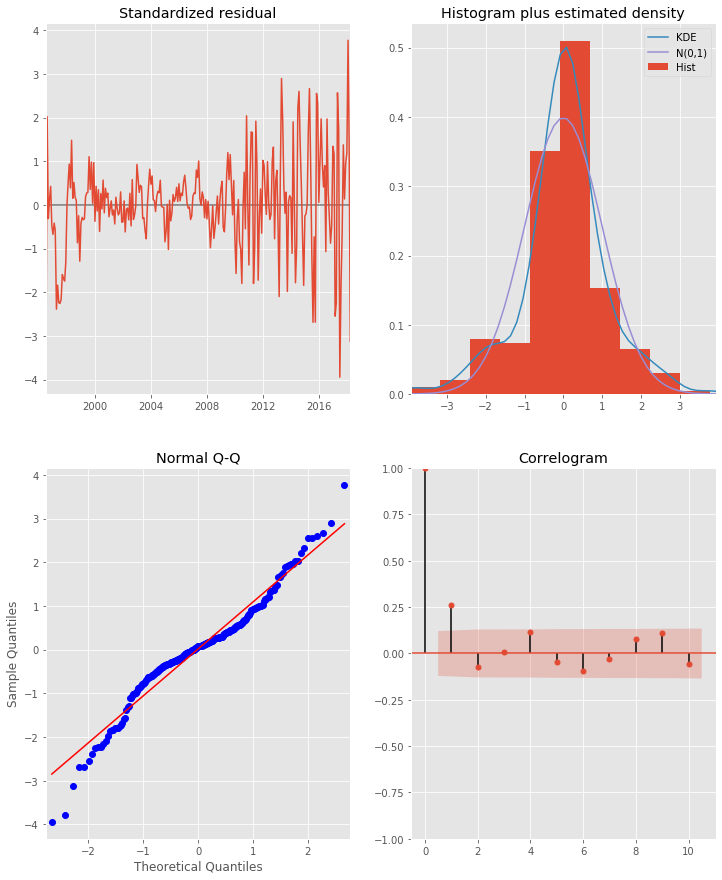

In [244]:
# Use plot_diagnostics with results calculated above.
output_a.plot_diagnostics(figsize=(12, 15))
plt.show()

None of these plots look particularly good, the patterns of the residuals change, the KDE line is different from the N(0,1) line, the Q-Q residuals don't lie on the red line and there are many lag values that appear to be significant.

### SARIMAX model

The code below tests different combinations of the model and returns an AIC value for each. From this we can select the best model

In [245]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [246]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_model,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7304.023638118579
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6797.178603410834
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5662.7448006993445
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5373.072187632091
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5677.487620525852
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5771.0283310158575
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5313.910827879212
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5270.615704790406
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7086.3770547323165
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6718.831165008302
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5681.758871431868
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =7736.808681638689
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6750.885986677662
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6699.36837656467
ARIMA (0, 0, 1) x 

In [247]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]



pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic            3629.7
Name: 59, dtype: object

In [248]:
print("The best model is ARIMA {}".format(ans_df.loc[ans_df['aic'].idxmin()].values))

The best model is ARIMA [(1, 1, 1) (0, 1, 1, 12) 3629.704915944589]


### Model Output and Plot Diagnostics

### Best fit using loop

Now run the model using the parameters above

In [249]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1810.852
Date:                            Mon, 28 Oct 2019   AIC                           3629.705
Time:                                    01:30:13   BIC                           3643.594
Sample:                                04-01-1996   HQIC                          3635.302
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8173      0.028     28.828      0.000       0.762       0.873
ma.L1          0.6369      0.034   

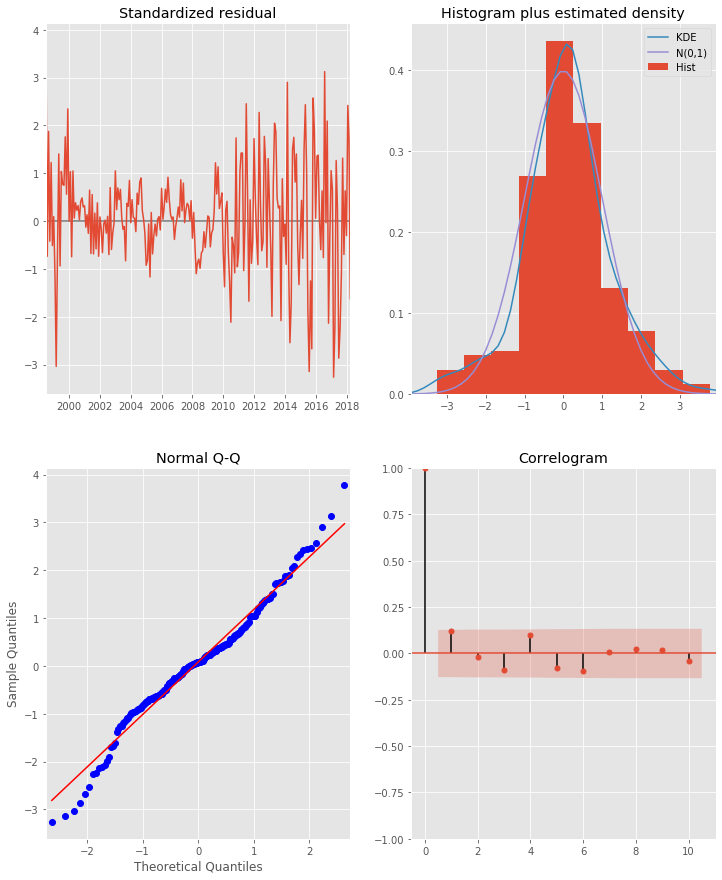

In [250]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

The residual plots are much improved and look reasonable here

### Best fit with higher order model

I also ran a higher order loop earlier, which returned the following parameters. I have not included the calculation in this notebook, because it took a long time to run and returned over 700 lines. I will run this model and compare the parameters.

In [251]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 2, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1668.836
Date:                            Mon, 28 Oct 2019   AIC                           3351.673
Time:                                    01:30:35   BIC                           3375.169
Sample:                                04-01-1996   HQIC                          3361.169
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9458      0.008    111.301      0.000       0.929       0.962
ma.L1         -0.3744      0.072   

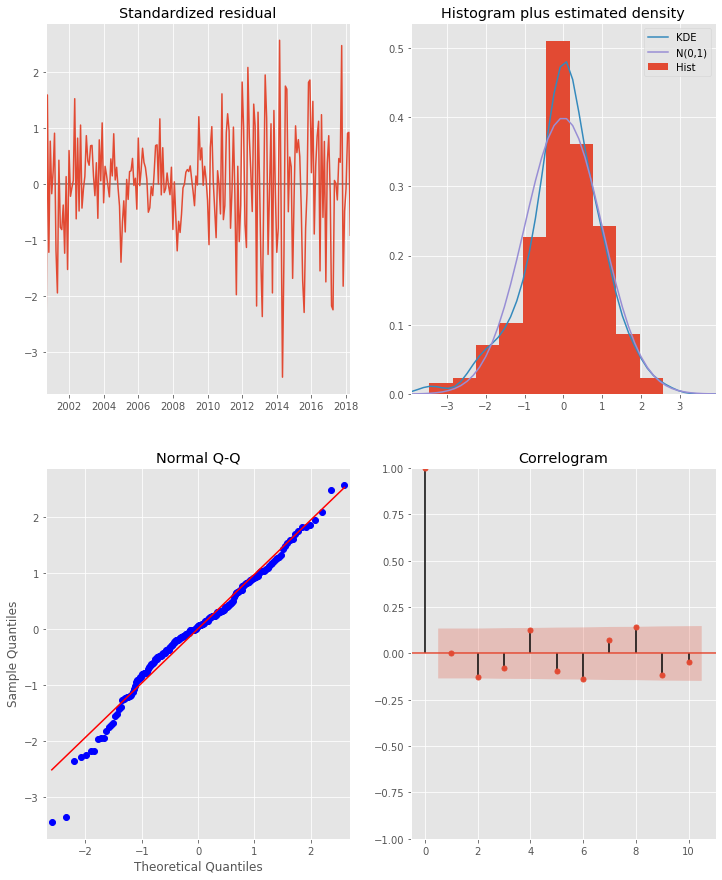

In [252]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

This model has a slightly supperior AIC. However it is more complicated and has a higher order of differencing, so it is debatable whether it is a better model. 

### Test Train Split

This point would be where we fit the model to a training data set, and then use the remaining portion of the data as a test. Once we are satisfied with the result we would refit the model to the entire database and forecast the future!

In the interests of time and space I have not done this in this project. The code would look something like:

In [253]:
# train = data.loc['1996-04':'2015-12']
# test = data.loc['2016-01':]

# output.fit(train)

### Get Predictions

In [254]:
df_zip = df_model['value'].resample('MS').mean()

#### One Step Ahead

First building a "one step ahead model" where each predicted value is based on the actual value immediately before it

In [255]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

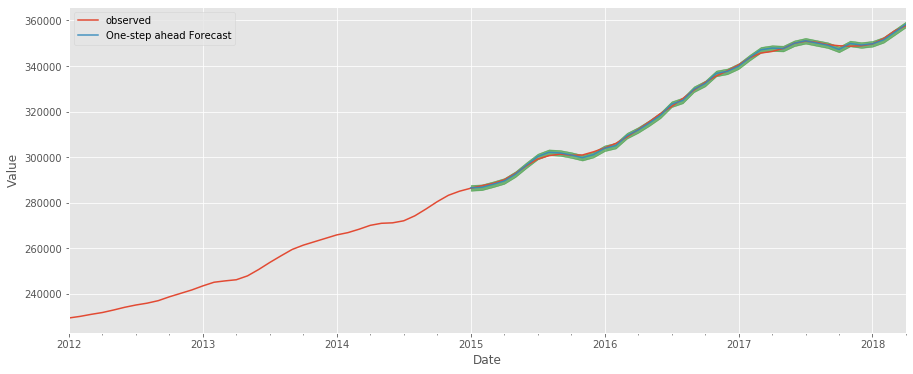

In [256]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = df_zip['2012':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

plt.show()

As expected, the "one step ahead" forecast is very close the actual value. We are only forecasting a month ahead each time, so this is not a realistic model

In [257]:
# Get the Real and predicted values
forecasted = pred.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 577524.25


#### Dynamic Prediction

Now our forecast uses the previous predicted value to make its next prediction. In this case the forecast begins in 2015 

In [258]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

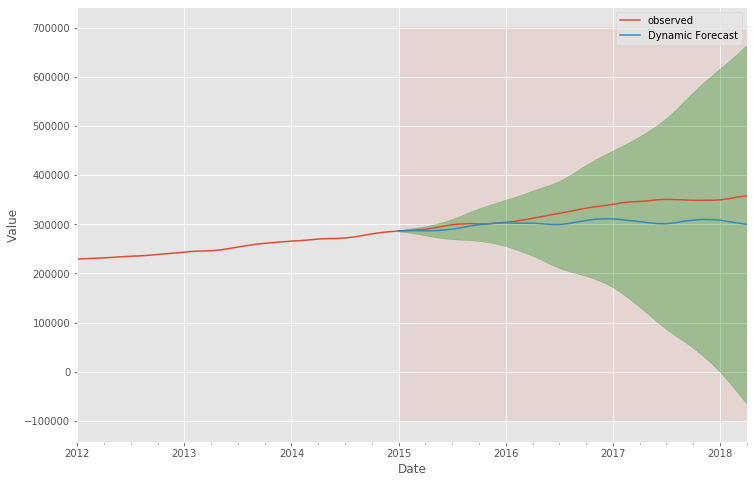

In [259]:
# Plot the dynamic forecast with confidence intervals as above
ax = df_zip['2012':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.legend()
plt.show()


This forecast diverges from the actual a lot more than the one step ahead model

In [260]:
# Extract the predicted and true values of our time series
forecasted = pred_dynamic.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 887992080.76


The Mean Squared Error looks massive, because it is based on house values in hundreds of thousands of dollars, which are then squared. To see how it relates to housing prices we need to take the square root of it.

In [261]:
mse_sqrt = np.sqrt(mse)
print("The Square Root of the MSE at {} doesn't look as bad".format(round(mse_sqrt,0)))

The Square Root of the MSE at 29799.0 doesn't look as bad


### Forecasting the future

In [262]:
# Get the forecast 60 months ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

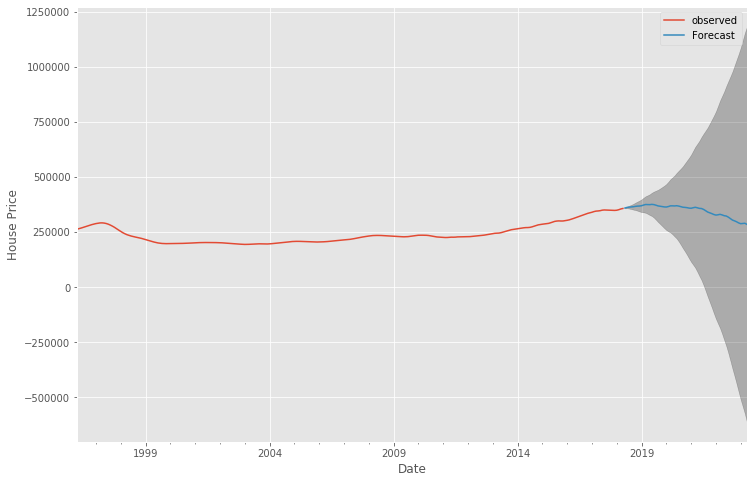

In [263]:
# Plot future predictions with confidence intervals

ax = df_zip.plot(label='observed', figsize=(12,8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Price')

plt.legend()
plt.show()

This forecast builds into the future. It shows the next 60 steps, or 5 years, or until 04-2023. There is a very large area under the confidence intervals - uncertainty increases dramatically after the first year or two.

#### Building a table of zip code forecasts

In [264]:
fcst = (output.forecast(steps=60).tail(1).sum())
actual = df_model.iloc[-1].value

In [265]:
fcst

285590.68769774

In [266]:
actual

357700.0

In [267]:
zipdf2 = pd.DataFrame({"zip":[zip], 
                    "last_actual":[actual],
                    "last_fcst":fcst}) 

In [268]:
zipdf1 = zipdf1.append(zipdf2)

In [269]:
zipdf1

zip  last_actual      last_fcst
0  78660     242800.0  289337.630895
0  78704     550900.0  761213.896983
0  78741     250400.0  521912.325116
0  78744     195500.0  330606.085019
0  78745     294700.0  277517.458552
0  78748     282000.0  294581.045113
0  78749     357700.0  285590.687698

## Zip Code 78753

In [270]:
zip = 78753
df_model = df_78753

### ARIMA model

First test a simple ARIMA model, with no seasonality

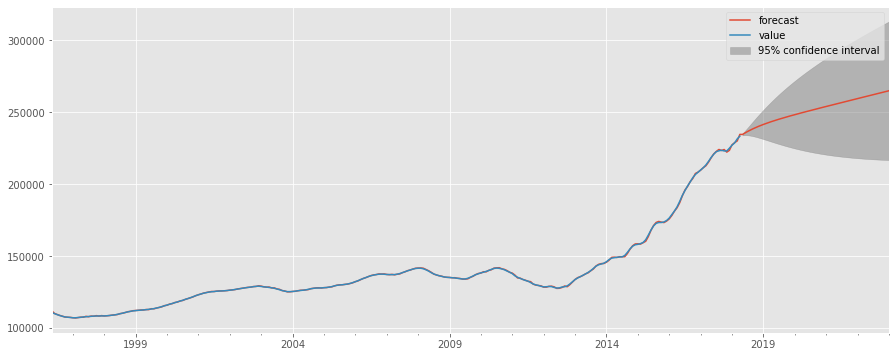

In [271]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast prices using an ARIMA(1,1,1) model
mod = ARIMA(df_model, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(end='2023-01-01')
plt.show()

In [272]:
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1899.443
Method:                       css-mle   S.D. of innovations            321.049
Date:                Mon, 28 Oct 2019   AIC                           3806.887
Time:                        01:30:42   BIC                           3821.191
Sample:                    05-01-1996   HQIC                          3812.634
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           452.8673    217.087      2.086      0.038      27.385     878.350
ar.L1.D.value     0.8729      0.031     27.764      0.000       0.811       0.934
ma.L1.D.value     0.4340      0.056     

In [273]:
print("The ARIMA model has an AIC of {}".format(round(res.aic,0)))

The ARIMA model has an AIC of 3807.0


Load the ARIMA model into SARIMAX, in order to access plot diagnosis

In [274]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_a = ARIMA_MODEL.fit()

print(output_a.summary())

                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1888.110
Date:                Mon, 28 Oct 2019   AIC                           3782.221
Time:                        01:30:42   BIC                           3792.926
Sample:                    04-01-1996   HQIC                          3786.523
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9062      0.019     46.645      0.000       0.868       0.944
ma.L1          0.3823      0.034     11.159      0.000       0.315       0.449
sigma2      1.053e+05   5232.572     20.117      0.0

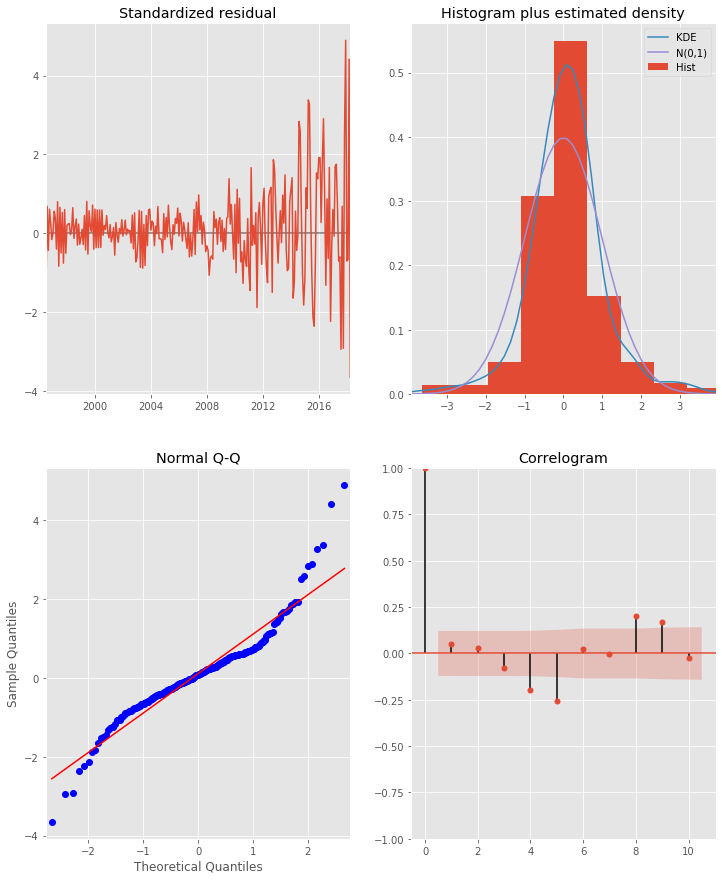

In [275]:
# Use plot_diagnostics with results calculated above.
output_a.plot_diagnostics(figsize=(12, 15))
plt.show()

None of these plots look good, the patterns of the residuals change, the KDE line is different from the N(0,1) line, the Q-Q residuals don't lie on the red line and there are many lag values that appear to be significant.

### SARIMAX model

The code below tests different combinations of the model and returns an AIC value for each. From this we can select the best model

In [276]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [277]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_model,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7013.99751299524
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6535.727296965228
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5388.973588566773
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5144.685126130712
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5298.022646213203
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5277.062225284805
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =4963.529006286777
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =6304.289073488288
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6797.583230021313
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6444.690373608304
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5214.545486984091
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =6944.712910597709
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6474.396151361116
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6425.114556829504
ARIMA (0, 0, 1) x (1,

In [278]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]



pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           3511.87
Name: 59, dtype: object

In [279]:
print("The best model is ARIMA {}".format(ans_df.loc[ans_df['aic'].idxmin()].values))

The best model is ARIMA [(1, 1, 1) (0, 1, 1, 12) 3511.8695055711864]


### Model Output and Plot Diagnostics

### Best fit using loop

Now run the model using the parameters above

In [280]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1751.935
Date:                            Mon, 28 Oct 2019   AIC                           3511.870
Time:                                    01:31:26   BIC                           3525.759
Sample:                                04-01-1996   HQIC                          3517.467
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8161      0.029     27.819      0.000       0.759       0.874
ma.L1          0.4561      0.030   

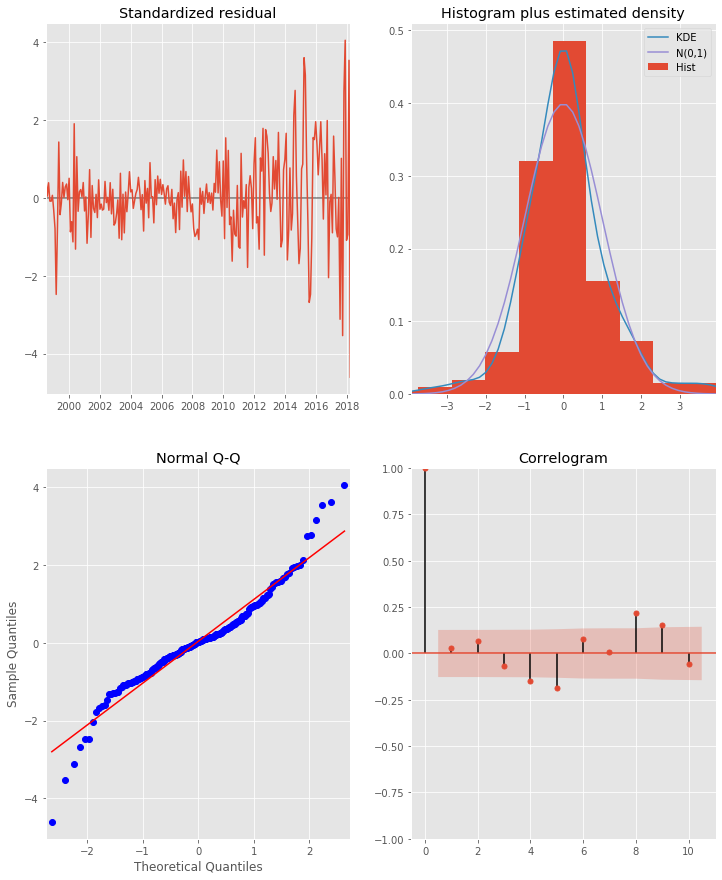

In [281]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

There are still issues with all of these plots

### Best fit with higher order model

I also ran a higher order loop earlier, which returned the following parameters. I have not included the calculation in this notebook, because it took a long time to run and returned over 700 lines. I will run this model and compare the parameters.

In [282]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 2, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1619.515
Date:                            Mon, 28 Oct 2019   AIC                           3253.031
Time:                                    01:31:44   BIC                           3276.527
Sample:                                04-01-1996   HQIC                          3262.527
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9022      0.025     35.587      0.000       0.853       0.952
ma.L1         -0.5747      0.084   

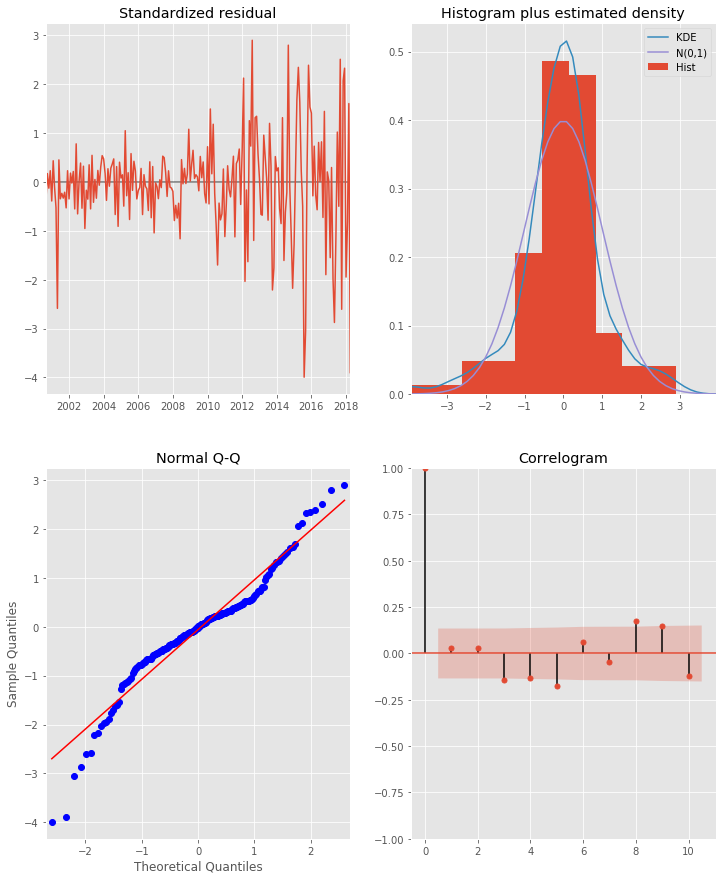

In [283]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

This model has a slightly supperior AIC, and improved residual plots. However it is more complicated and has a higher order of differencing, so it is debatable whether it is a better model. 

### Test Train Split

This point would be where we fit the model to a training data set, and then use the remaining portion of the data as a test. Once we are satisfied with the result we would refit the model to the entire database and forecast the future!

In the interests of time and space I have not done this in this project. The code would look something like:

In [284]:
# train = data.loc['1996-04':'2015-12']
# test = data.loc['2016-01':]

# output.fit(train)

### Get Predictions

In [285]:
df_zip = df_model['value'].resample('MS').mean()

#### One Step Ahead

First building a "one step ahead model" where each predicted value is based on the actual value immediately before it

In [286]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

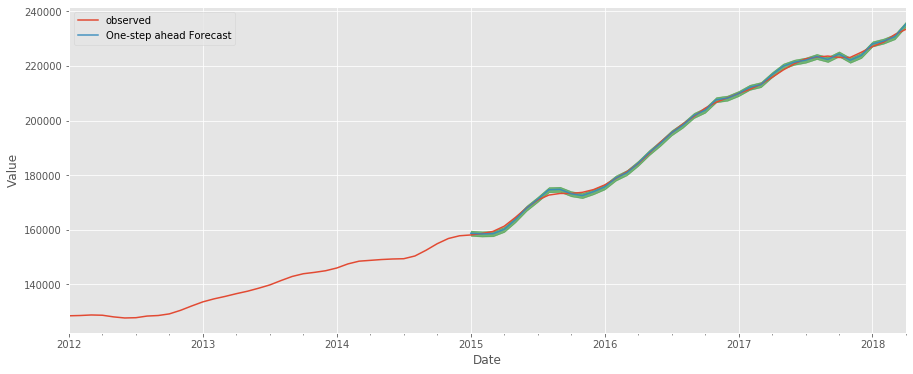

In [287]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = df_zip['2012':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

plt.show()

As expected, the "one step ahead" forecast is very close the actual value. We are only forecasting a month ahead each time, so this is not a realistic model

In [288]:
# Get the Real and predicted values
forecasted = pred.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 719235.17


#### Dynamic Prediction

Now our forecast uses the previous predicted value to make its next prediction. In this case the forecast begins in 2015 

In [289]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

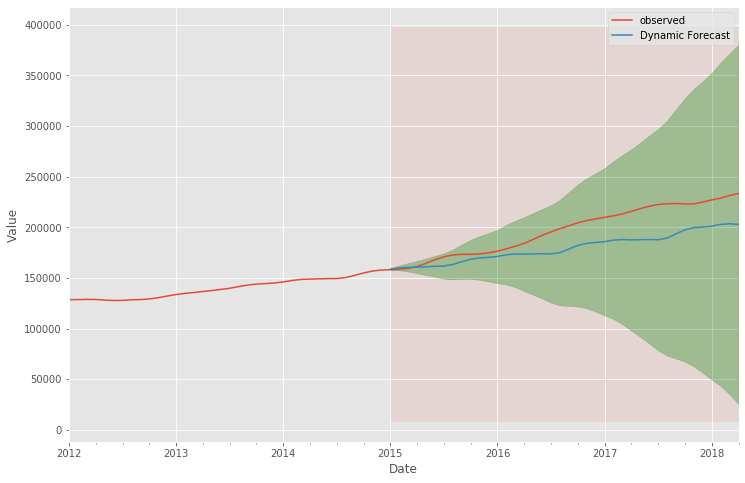

In [290]:
# Plot the dynamic forecast with confidence intervals as above
ax = df_zip['2012':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.legend()
plt.show()


This forecast diverges from the actual a lot more than the one step ahead model

In [291]:
# Extract the predicted and true values of our time series
forecasted = pred_dynamic.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 424612302.42


The Mean Squared Error looks massive, because it is based on house values in hundreds of thousands of dollars, which are then squared. To see how it relates to housing prices we need to take the square root of it.

In [292]:
mse_sqrt = np.sqrt(mse)
print("The Square Root of the MSE at {} doesn't look as bad".format(round(mse_sqrt,0)))

The Square Root of the MSE at 20606.0 doesn't look as bad


### Forecasting the future

In [293]:
# Get the forecast 60 months ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

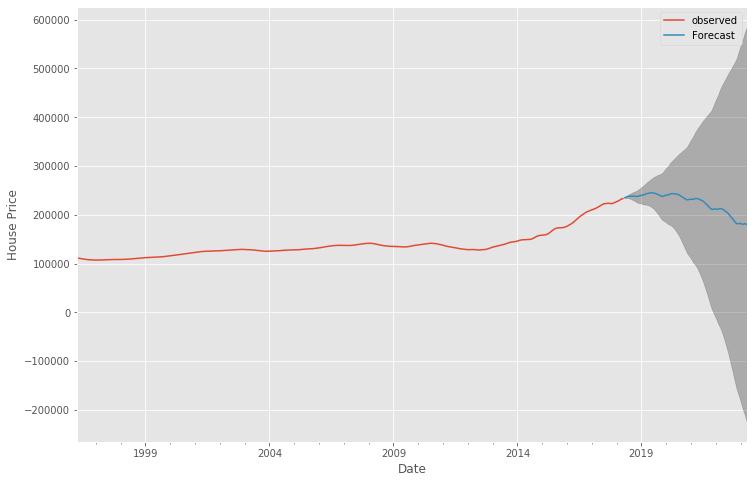

In [294]:
# Plot future predictions with confidence intervals

ax = df_zip.plot(label='observed', figsize=(12,8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Price')

plt.legend()
plt.show()

This forecast builds into the future. It shows the next 60 steps, or 5 years, or until 04-2023. There is a very large area under the confidence intervals - uncertainty increases dramatically after the first year or two.

#### Building a table of zip code forecasts

In [295]:
fcst = (output.forecast(steps=60).tail(1).sum())
actual = df_model.iloc[-1].value

In [296]:
fcst

180330.74697515977

In [297]:
actual

233400.0

In [298]:
zipdf2 = pd.DataFrame({"zip":[zip], 
                    "last_actual":[actual],
                    "last_fcst":fcst}) 

In [299]:
zipdf1 = zipdf1.append(zipdf2)

In [300]:
zipdf1

zip  last_actual      last_fcst
0  78660     242800.0  289337.630895
0  78704     550900.0  761213.896983
0  78741     250400.0  521912.325116
0  78744     195500.0  330606.085019
0  78745     294700.0  277517.458552
0  78748     282000.0  294581.045113
0  78749     357700.0  285590.687698
0  78753     233400.0  180330.746975

## Zip Code 78758

In [301]:
zip = 78758
df_model = df_78758

### ARIMA model

First test a simple ARIMA model, with no seasonality

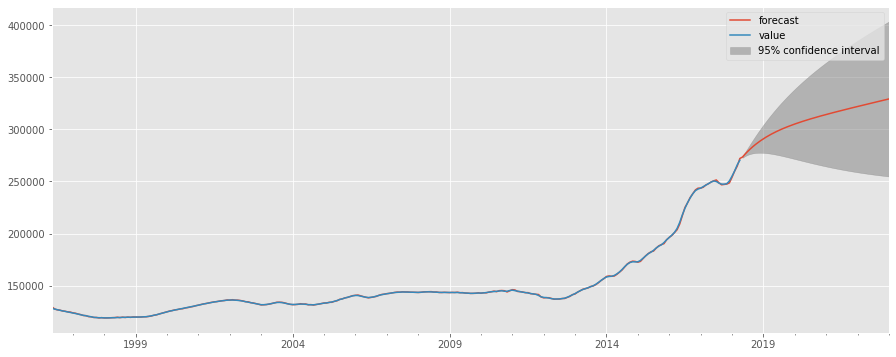

In [302]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast prices using an ARIMA(1,1,1) model
mod = ARIMA(df_model, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(end='2023-01-01')
plt.show()

In [303]:
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1930.979
Method:                       css-mle   S.D. of innovations            361.357
Date:                Mon, 28 Oct 2019   AIC                           3869.959
Time:                        01:31:49   BIC                           3884.263
Sample:                    05-01-1996   HQIC                          3875.707
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           589.3090    346.008      1.703      0.090     -88.855    1267.472
ar.L1.D.value     0.9024      0.028     32.602      0.000       0.848       0.957
ma.L1.D.value     0.5710      0.045     

In [304]:
print("The ARIMA model has an AIC of {}".format(round(res.aic,0)))

The ARIMA model has an AIC of 3870.0


Load the ARIMA model into SARIMAX, in order to access plot diagnosis

In [305]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_a = ARIMA_MODEL.fit()

print(output_a.summary())

                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1920.619
Date:                Mon, 28 Oct 2019   AIC                           3847.239
Time:                        01:31:50   BIC                           3857.944
Sample:                    04-01-1996   HQIC                          3851.541
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9286      0.013     70.562      0.000       0.903       0.954
ma.L1          0.5070      0.035     14.684      0.000       0.439       0.575
sigma2      1.325e+05   5572.221     23.778      0.0

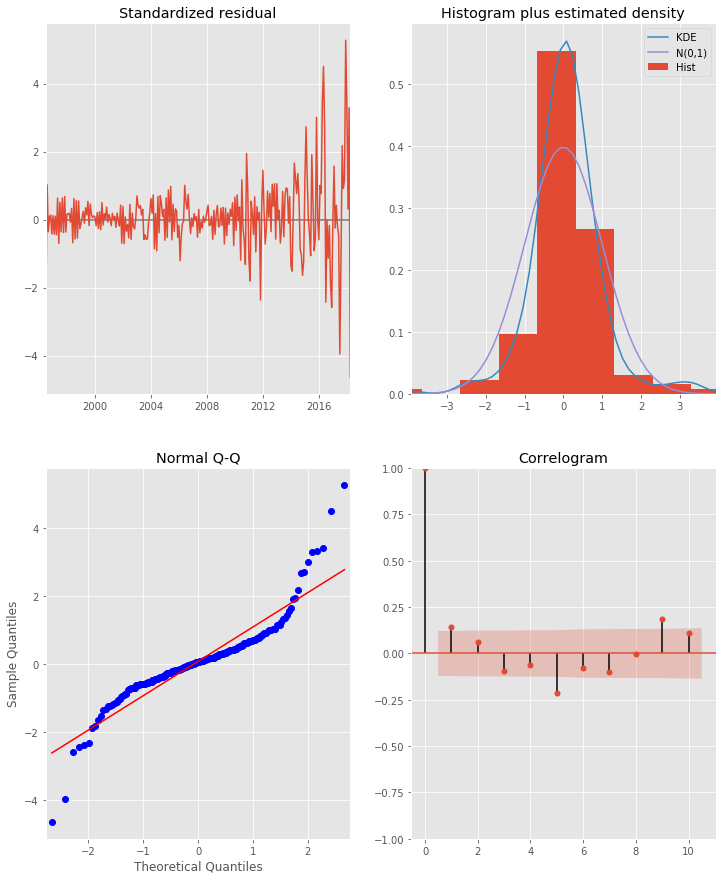

In [306]:
# Use plot_diagnostics with results calculated above.
output_a.plot_diagnostics(figsize=(12, 15))
plt.show()

None of these plots look good, the patterns of the residuals changes, the KDE line is different from the N(0,1) line, the Q-Q residuals don't lie on the red line and there are many lag values that appear to be significant.

### SARIMAX model

The code below tests different combinations of the model and returns an AIC value for each. From this we can select the best model

In [307]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [308]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_model,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7056.217131442367
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6574.740896857411
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5490.653305741313
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5239.918967371611
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5417.817428212937
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5398.681980161073
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5103.250154499072
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =6491.921399658092
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6839.672621061676
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =6805.598649814332
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5314.797545863608
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =8000.055430297082
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6514.650389877352
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =6794.973986734394
ARIMA (0, 0, 1) x (1

In [309]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]



pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic            3585.6
Name: 59, dtype: object

In [310]:
print("The best model is ARIMA {}".format(ans_df.loc[ans_df['aic'].idxmin()].values))

The best model is ARIMA [(1, 1, 1) (0, 1, 1, 12) 3585.6015444464506]


### Model Output and Plot Diagnostics

### Best fit using loop

Now run the model using the parameters above

In [311]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1788.801
Date:                            Mon, 28 Oct 2019   AIC                           3585.602
Time:                                    01:32:33   BIC                           3599.491
Sample:                                04-01-1996   HQIC                          3591.199
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8545      0.018     46.273      0.000       0.818       0.891
ma.L1          0.6001      0.035   

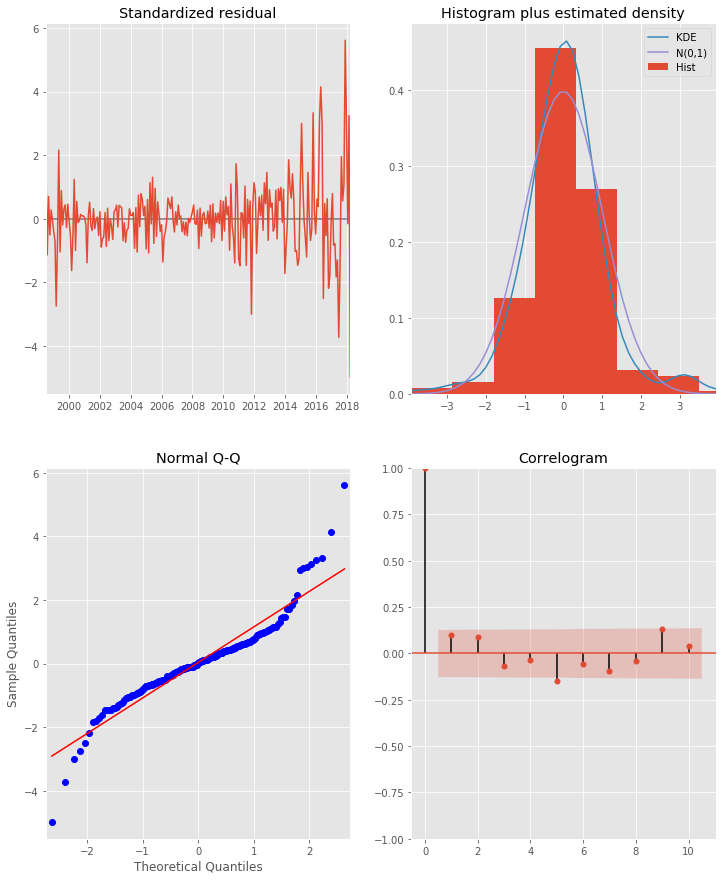

In [312]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

There are still issues with all of these plots

### Best fit with higher order model

I also ran a higher order loop earlier, which returned the following parameters. I have not included the calculation in this notebook, because it took a long time to run and returned over 700 lines. I will run this model and compare the parameters.

In [313]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 2, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1666.111
Date:                            Mon, 28 Oct 2019   AIC                           3346.222
Time:                                    01:32:52   BIC                           3369.718
Sample:                                04-01-1996   HQIC                          3355.719
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7990      0.055    -14.585      0.000      -0.906      -0.692
ma.L1          1.6189      0.039   

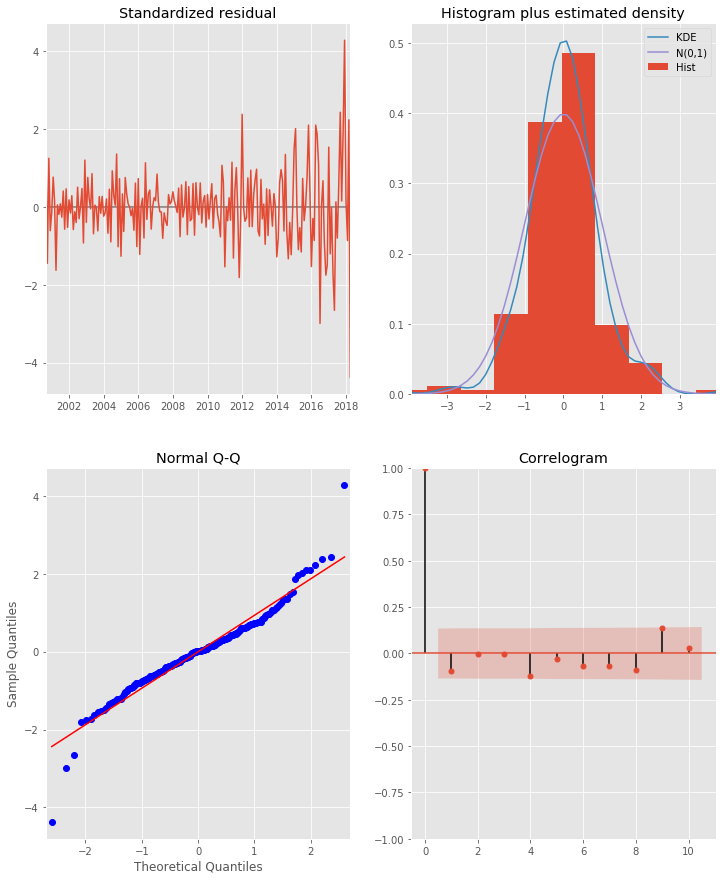

In [314]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

This model has a slightly supperior AIC and improved residual plots. However it is more complicated and has a higher order of differencing, so it is debatable whether it is a better model.


### Test Train Split

This point would be where we fit the model to a training data set, and then use the remaining portion of the data as a test. Once we are satisfied with the result we would refit the model to the entire database and forecast the future!

In the interests of time and space I have not done this in this project. The code would look something like:

In [315]:
# train = data.loc['1996-04':'2015-12']
# test = data.loc['2016-01':]

# output.fit(train)

### Get Predictions

In [316]:
df_zip = df_model['value'].resample('MS').mean()

#### One Step Ahead

First building a "one step ahead model" where each predicted value is based on the actual value immediately before it

In [317]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

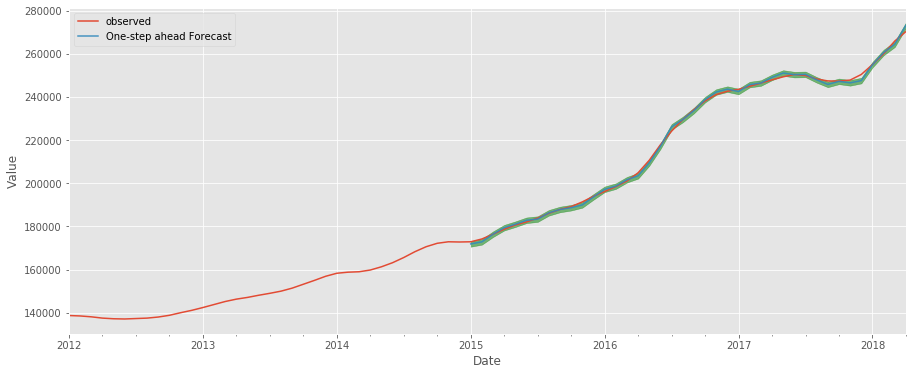

In [318]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = df_zip['2012':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

plt.show()

As expected, the "one step ahead" forecast is very close the actual value. We are only forecasting a month ahead each time, so this is not a realistic model

In [319]:
# Get the Real and predicted values
forecasted = pred.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 1220745.03


#### Dynamic Prediction

Now our forecast uses the previous predicted value to make its next prediction. In this case the forecast begins in 2015 

In [320]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

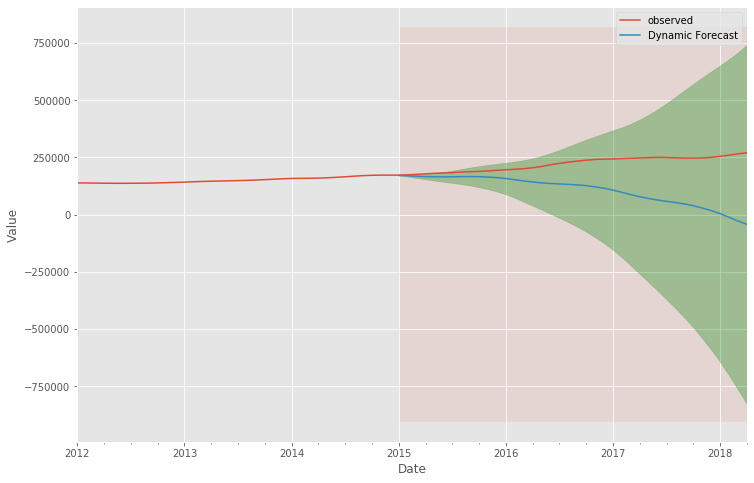

In [321]:
# Plot the dynamic forecast with confidence intervals as above
ax = df_zip['2012':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.legend()
plt.show()


This forecast diverges from the actual a lot more than the one step ahead model

In [322]:
# Extract the predicted and true values of our time series
forecasted = pred_dynamic.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 20987572550.41


The Mean Squared Error looks massive, because it is based on house values in hundreds of thousands of dollars, which are then squared. To see how it relates to housing prices we need to take the square root of it.

In [323]:
mse_sqrt = np.sqrt(mse)
print("The Square Root of the MSE at {} doesn't look as bad".format(round(mse_sqrt,0)))

The Square Root of the MSE at 144871.0 doesn't look as bad


### Forecasting the future

In [324]:
# Get the forecast 60 months ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

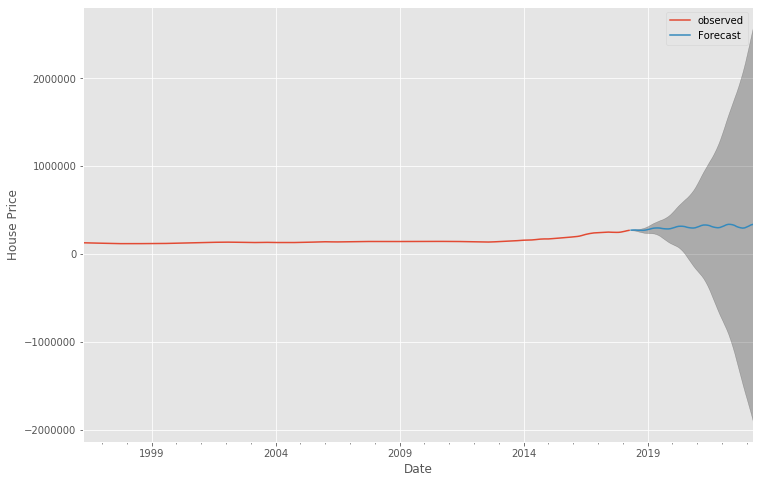

In [325]:
# Plot future predictions with confidence intervals

ax = df_zip.plot(label='observed', figsize=(12,8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Price')

plt.legend()
plt.show()

This forecast builds into the future. It shows the next 60 steps, or 5 years, or until 04-2023. There is a very large area under the confidence intervals - uncertainty increases dramatically after the first year or two.

#### Building a table of zip code forecasts

In [326]:
fcst = (output.forecast(steps=60).tail(1).sum())
actual = df_model.iloc[-1].value

In [327]:
fcst

338562.26960808574

In [328]:
actual

270400.0

In [329]:
zipdf2 = pd.DataFrame({"zip":[zip], 
                    "last_actual":[actual],
                    "last_fcst":fcst}) 

In [330]:
zipdf1 = zipdf1.append(zipdf2)

In [331]:
zipdf1

zip  last_actual      last_fcst
0  78660     242800.0  289337.630895
0  78704     550900.0  761213.896983
0  78741     250400.0  521912.325116
0  78744     195500.0  330606.085019
0  78745     294700.0  277517.458552
0  78748     282000.0  294581.045113
0  78749     357700.0  285590.687698
0  78753     233400.0  180330.746975
0  78758     270400.0  338562.269608

## Zip Code 78759

In [332]:
zip = 78759
df_model = df_78759

### ARIMA model

First test a simple ARIMA model, with no seasonality

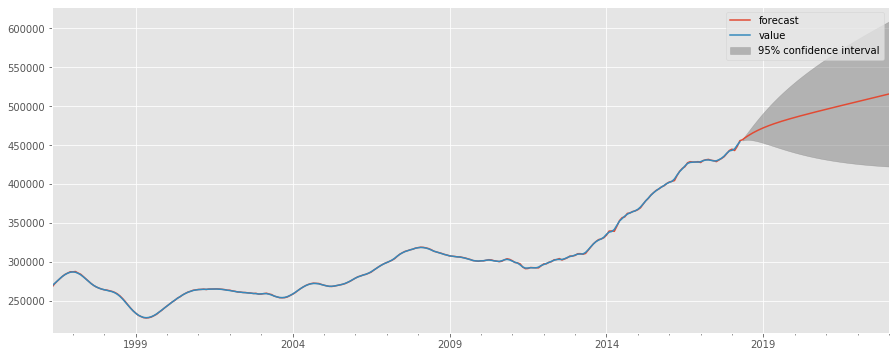

In [333]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast prices using an ARIMA(1,1,1) model
mod = ARIMA(df_model, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(end='2023-01-01')
plt.show()

In [334]:
print(res.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  264
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2025.914
Method:                       css-mle   S.D. of innovations            517.504
Date:                Mon, 28 Oct 2019   AIC                           4059.828
Time:                        01:32:57   BIC                           4074.132
Sample:                    05-01-1996   HQIC                          4065.576
                         - 04-01-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           812.7120    420.770      1.931      0.055     -11.982    1637.406
ar.L1.D.value     0.8729      0.030     28.868      0.000       0.814       0.932
ma.L1.D.value     0.7217      0.036     

In [335]:
print("The ARIMA model has an AIC of {}".format(round(res.aic,0)))

The ARIMA model has an AIC of 4060.0


Load the ARIMA model into SARIMAX, in order to access plot diagnosis

In [336]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output_a = ARIMA_MODEL.fit()

print(output_a.summary())

                           Statespace Model Results                           
Dep. Variable:                  value   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2043.025
Date:                Mon, 28 Oct 2019   AIC                           4092.050
Time:                        01:32:57   BIC                           4102.755
Sample:                    04-01-1996   HQIC                          4096.352
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9083      0.020     46.118      0.000       0.870       0.947
ma.L1          0.3375      0.014     24.470      0.000       0.310       0.365
sigma2      2.961e+05   1.41e+04     21.025      0.0

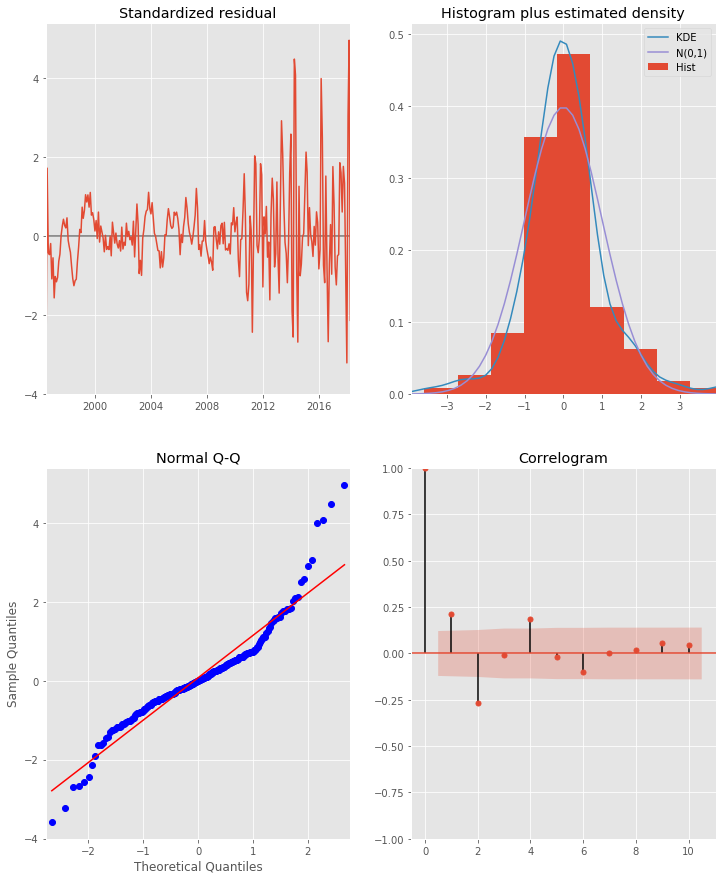

In [337]:
# Use plot_diagnostics with results calculated above.
output_a.plot_diagnostics(figsize=(12, 15))
plt.show()

None of these plots look good, the patterns of the residuals changes, the KDE line is different from the N(0,1) line, the Q-Q residuals don't lie on the red line and there are many lag values that appear to be significant.

### SARIMAX model

The code below tests different combinations of the model and returns an AIC value for each. From this we can select the best model

In [338]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [339]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_model,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7425.90796748078
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =959284.6622397111
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =5673.893790425204
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =5407.307221570549
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =5640.45169893822
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =5633.73756208872
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =5328.435496090513
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5304.850423046097
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7207.89106801111
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =969246.7512892437
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =5698.224940543702
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =5345.0312226980495
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =6868.658817464156
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =7213.672233718536
ARIMA (0, 0, 1) x (1, 1

In [340]:
# Find the parameters with minimal AIC value.
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]



pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           3774.33
Name: 63, dtype: object

In [341]:
print("The best model is ARIMA {}".format(ans_df.loc[ans_df['aic'].idxmin()].values))

The best model is ARIMA [(1, 1, 1) (1, 1, 1, 12) 3774.32831199335]


### Model Output and Plot Diagnostics

### Best fit using loop

Now run the model using the parameters above

In [365]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1882.164
Date:                            Mon, 28 Oct 2019   AIC                           3774.328
Time:                                    01:43:04   BIC                           3791.690
Sample:                                04-01-1996   HQIC                          3781.325
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8273      0.036     23.049      0.000       0.757       0.898
ma.L1          0.7118      0.035   

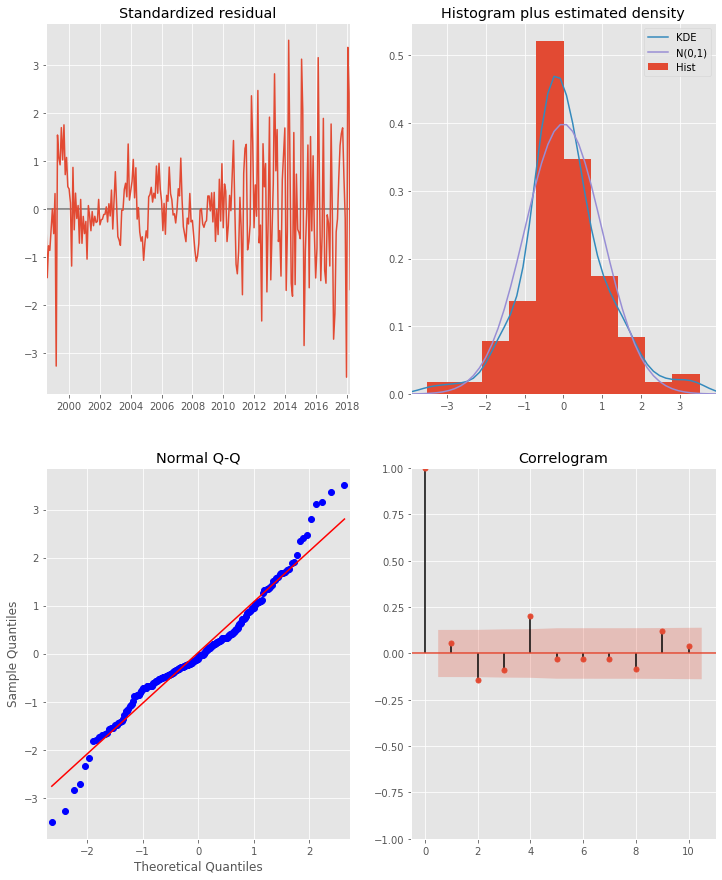

In [366]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

There are still issues with all of these plots

### Best fit with higher order model

I also ran a higher order loop earlier, which returned the following parameters. I have not included the calculation in this notebook, because it took a long time to run and returned over 700 lines. I will run this model and compare the parameters.

In [344]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_model,
                                order=(1, 2, 2),
                                seasonal_order=(1, 2, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1735.668
Date:                            Mon, 28 Oct 2019   AIC                           3485.336
Time:                                    01:34:03   BIC                           3508.832
Sample:                                04-01-1996   HQIC                          3494.832
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2198      0.187     -1.177      0.239      -0.586       0.146
ma.L1          1.0321      0.179   

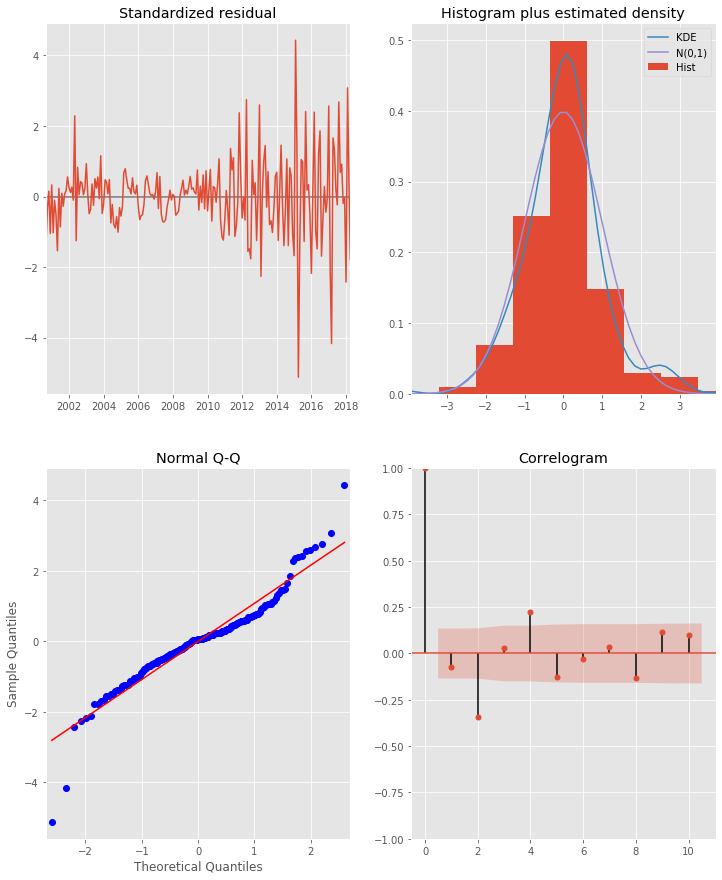

In [345]:
# Use plot_diagnostics with results calculated above.
output.plot_diagnostics(figsize=(12, 15))
plt.show()

This model has a slightly supperior AIC. However it is more complicated and has a higher order of differencing, so it is debatable whether it is a better model.

### Test Train Split

This point would be where we fit the model to a training data set, and then use the remaining portion of the data as a test. Once we are satisfied with the result we would refit the model to the entire database and forecast the future!

In the interests of time and space I have not done this in this project. The code would look something like:

In [346]:
# train = data.loc['1996-04':'2015-12']
# test = data.loc['2016-01':]

# output.fit(train)

### Get Predictions

In [347]:
df_zip = df_model['value'].resample('MS').mean()

#### One Step Ahead

First building a "one step ahead model" where each predicted value is based on the actual value immediately before it

In [348]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals.

pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

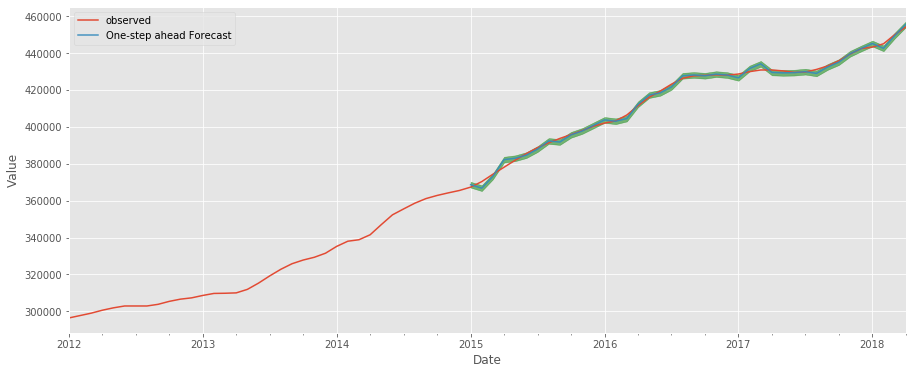

In [349]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = df_zip['2012':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()

plt.show()

As expected, the "one step ahead" forecast is very close the actual value. We are only forecasting a month ahead each time, so this is not a realistic model

In [350]:
# Get the Real and predicted values
forecasted = pred.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 2325405.9


#### Dynamic Prediction

Now our forecast uses the previous predicted value to make its next prediction. In this case the forecast begins in 2015 

In [351]:
# Get dynamic predictions with confidence intervals as above.
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

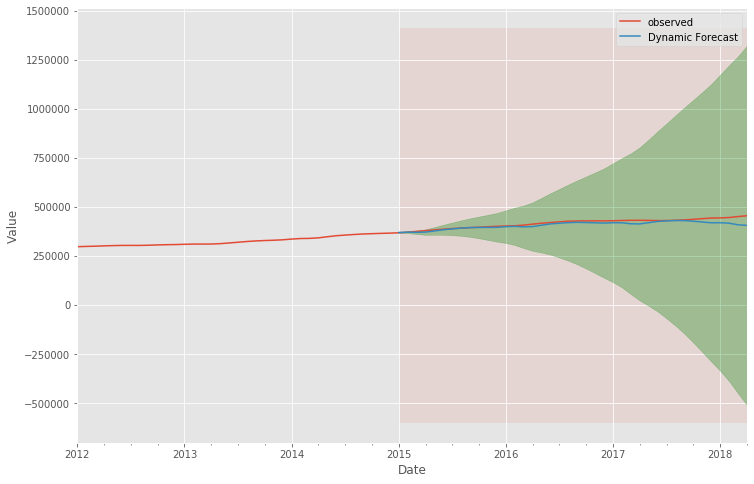

In [352]:
# Plot the dynamic forecast with confidence intervals as above
ax = df_zip['2012':].plot(label='observed', figsize=(12, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.legend()
plt.show()


This forecast diverges from the actual a lot more than the one step ahead model

In [353]:
# Extract the predicted and true values of our time series
forecasted = pred_dynamic.predicted_mean
truth = df_zip['2015-01-01':]

# Compute the mean square error
mse = ((forecasted - truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 215954623.82


The Mean Squared Error looks massive, because it is based on house values in hundreds of thousands of dollars, which are then squared. To see how it relates to housing prices we need to take the square root of it.

In [354]:
mse_sqrt = np.sqrt(mse)
print("The Square Root of the MSE at {} doesn't look as bad".format(round(mse_sqrt,0)))

The Square Root of the MSE at 14695.0 doesn't look as bad


### Forecasting the future

In [355]:
# Get the forecast 60 months ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

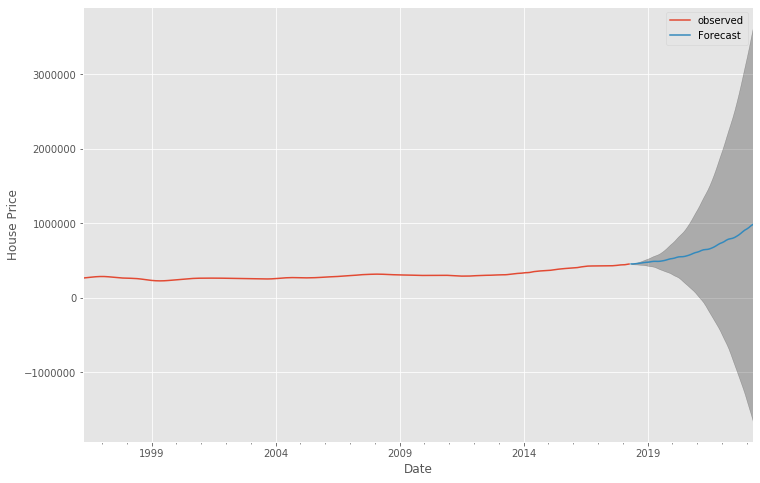

In [356]:
# Plot future predictions with confidence intervals

ax = df_zip.plot(label='observed', figsize=(12,8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('House Price')

plt.legend()
plt.show()

This forecast builds into the future. It shows the next 60 steps, or 5 years, or until 04-2023. There is a very large area under the confidence intervals - uncertainty increases dramatically after the first year or two.

#### Building a table of zip code forecasts

In [357]:
fcst = (output.forecast(steps=60).tail(1).sum())
actual = df_model.iloc[-1].value

In [358]:
fcst

986603.7759102787

In [359]:
actual

454100.0

In [360]:
zipdf2 = pd.DataFrame({"zip":[zip], 
                    "last_actual":[actual],
                    "last_fcst":fcst}) 

In [361]:
zipdf1 = zipdf1.append(zipdf2)

In [362]:
zipdf1

zip  last_actual      last_fcst
0  78660     242800.0  289337.630895
0  78704     550900.0  761213.896983
0  78741     250400.0  521912.325116
0  78744     195500.0  330606.085019
0  78745     294700.0  277517.458552
0  78748     282000.0  294581.045113
0  78749     357700.0  285590.687698
0  78753     233400.0  180330.746975
0  78758     270400.0  338562.269608
0  78759     454100.0  986603.775910

# Step 5: Interpreting Results

In [363]:
zipdf1

zip  last_actual      last_fcst
0  78660     242800.0  289337.630895
0  78704     550900.0  761213.896983
0  78741     250400.0  521912.325116
0  78744     195500.0  330606.085019
0  78745     294700.0  277517.458552
0  78748     282000.0  294581.045113
0  78749     357700.0  285590.687698
0  78753     233400.0  180330.746975
0  78758     270400.0  338562.269608
0  78759     454100.0  986603.775910

In [372]:
zipdf1['growth'] = (zipdf1['last_fcst'] / zipdf1['last_actual'] -1)*100

In [373]:
zipdf1

zip  last_actual      last_fcst      growth
0  78660     242800.0  289337.630895   19.167064
0  78704     550900.0  761213.896983   38.176420
0  78741     250400.0  521912.325116  108.431440
0  78744     195500.0  330606.085019   69.107972
0  78745     294700.0  277517.458552   -5.830520
0  78748     282000.0  294581.045113    4.461364
0  78749     357700.0  285590.687698  -20.159159
0  78753     233400.0  180330.746975  -22.737469
0  78758     270400.0  338562.269608   25.207940
0  78759     454100.0  986603.775910  117.265751

### Top 5 zip codes in Austin

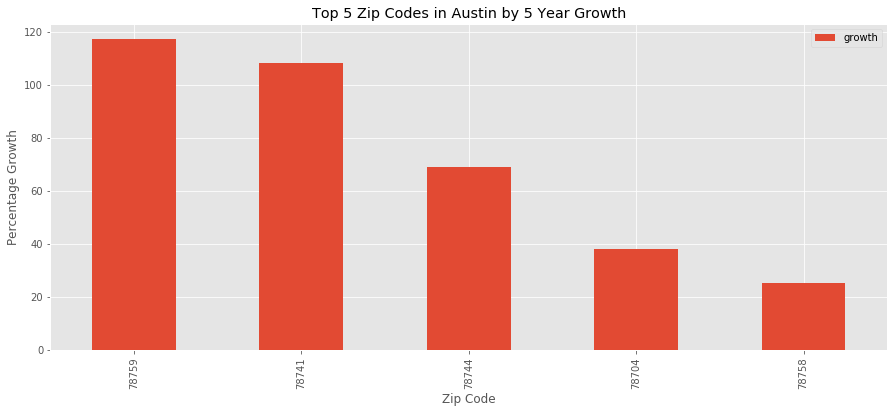

In [375]:
Top_zipcodes = zipdf1.nlargest(5, 'growth')
ax = Top_zipcodes.plot.bar(x='zip', y='growth')
ax.set_xlabel('Zip Code')
ax.set_ylabel('Percentage Growth')
ax.set_title('Top 5 Zip Codes in Austin by 5 Year Growth')
plt.show()

## Summary and Next Steps

Based on the models' predictions the 5 zip codes in the chart above are the best zip codes to invest in. The top two zip codes are predicted to double in value over the next 5 years.

Unfortunately most of the models were not a great fit, which would cause me to doubt the reliabilty of these models. Some of the future forecasts look suspicious - either too large or predicting declines in value. None of the 3 zip codes with the best plot diagnostics made the top 5 zip codes. The wide range of confidence intervals would indicate that 5 years may be too far out in the future for an accurate forecast.

Next steps would be to experiment further with the models. What is the difference in the data that is leading some zip codes to a predicted decline in price, and others to a massive gain? I would also like to experiment with different time periods. Maybe using data prior to the financial crisis in 2008 is adding unnecessary features to the model? How does a simplier model perform, even if it has larger AIC values? Finally I would like to add the train / test step into the modelling stage.
